<!-- block_a.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block A: AI Agent Architecture: Multi-Agent Planning, Response Storage, and Semantic Retrieval System **  


Block 1 – Import Libraries & Global Setup
 
•	Import Libraries:  
Import necessary modules for database communication, HTTP requests, data manipulation, logging, semantic search, and text processing.  
•	Define Global SYSTEM_PROMPT:  
A fixed prompt string instructs all agents to provide concise, factual responses.  
•	Define clean_response() Function:  
A utility function that strips out unwanted phrases and ensures the response is properly formatted.

*Block 2 – Database Configuration & URI*  
•	DB_CONFIG:  
A dictionary with credentials and connection details for the PostgreSQL database.  
•	DB_URI:  
A SQLAlchemy-compatible URI built from DB_CONFIG. This URI is later used when fetching data with pandas.

Block 3 – Define Planning Taxonomy  
•	PLANNING_AGENTS:  
A nested dictionary where keys are high-level planning categories and values are dictionaries mapping subcategories to lists of agent names.  
•	Categories and Subcategories within PLANNING_AGENTS:  
Organizes different reasoning approaches (e.g., single-path vs. multi-path) used later in the agent wrappers.  
•	populate_planning_taxonomy():  
Inserts planning categories and subcategories from the PLANNING_AGENTS dictionary into the database.

Block 4 – Database Setup Functions  
•	Logging in to the Database  
•	drop_existing_table():  
Drops all relevant tables if they exist to ensure a clean slate for testing.  
•	setup_database():  
Creates tables for planning categories, subcategories, agents, and performance metrics.  
  o	Note: The database defines generated_response for storing each agent's data.  
  o	TABLE planning_categories: Stores planning categories using data from populate_planning_taxonomy.  
  o	TABLE planning_subcategories: Stores planning subcategories using data from populate_planning_taxonomy.  
  o	TABLE agents: Stores agent information using Insert_agents_from_csv().  
  o	TABLE agent_pair_performance: Stores metrics of agent pairs after an agent produces an output. (The table task_performance is no longer used.)

Block 5 – Insert Agents from CSV  
•	Insert_agents_from_csv():  
Inserts agent details (e.g., planning, memory, action) from the Excel file agents.csv (see Notion link).  
  o	Also inserts the planning categories from the planning column of agents.csv into the database.

Block 6 – Response Storage Functions  
•	update_generated_response():  
Finds an agent in the database and appends a new response to its generated_response array.  
•	store_agent_response():  
Updates the agent’s record with a new response if it isn’t already stored.  
  o	Purpose: These functions persist the responses generated by the agents for later evaluation or semantic search.

Block 7 – LLM API Call Function (run_agent)  
•	Constructs full_prompt from SYSTEM_PROMPT and the user query.  
•	Sends an HTTP POST request to the tinyllama API endpoint (localhost:11434).  
•	Receives a JSON response, extracts the "response" field, cleans it, and truncates it if necessary.  
•	Calls update_generated_response() to save the agent's answer to the database.  
•	Note: Although tinyllama is used (suitable for an M1 MacBook), minor changes would allow switching to another model (e.g., GP4, llama3.1, O1).

Block 8 – Agent Wrapper Function  
•	Each wrapper (e.g., run_cot_langchain, run_zero_shot_cot) modifies the original query by appending additional instructions or modifying the prompt.  
  o	For example, run_zero_shot_cot adds “Let's think step by step” to encourage chain-of-thought reasoning.  
•	The response from run_cot_langchain is saved under the Chain of Thought (CoT) column in the agent database, and the agent’s response is appended to the generated_response TEXT array.  
•	Note: These individual agent functions can be modified according to the specific task being tested.

Block 9 – Process All Agents (process_agents)  
•	Calls setup_database(), populate_planning_taxonomy(), and insert_agents_from_csv() to prepare the database.  
•	Iterates over all defined agent wrapper functions to process a given query.  
•	Stores each agent’s response using the response storage functions.

Block 10 – Semantic Search Functionality  
•	Connects to the database via SQLAlchemy and fetches all stored agent responses.  
•	Uses a SentenceTransformer model to encode these responses into numerical embeddings.  
•	Builds a FAISS index from these embeddings.  
•	Searches the index for the top responses that are semantically similar to a provided search query.  
•	Purpose: Enables retrieval and comparison of the most relevant responses based on semantic similarity.
  1.	Data Retrieval: Fetches rows from the database containing agent responses.
  2.	Response Extraction: Aggregates all non-empty responses into a list.
  3.	Embedding Generation: Uses SentenceTransformer ("all-MiniLM-L6-v2") to generate numerical embeddings.
  4.	Index Building: Constructs a FAISS index using the L2 (Euclidean) distance metric.
  5.	Query Processing: Converts the search query into an embedding in the same vector space.
  6.	Nearest Neighbor Search: Retrieves the top_k most similar responses based on computed distances.
  7.	Result Return: Returns the text responses corresponding to the indices found.
  8.	Purpose of Semantic Search: Checks if the correct responses are selected by the top_k, aiding in further analysis.

Block 11 – Main Function  
•	The main function orchestrates all previous steps:  
  o	Resets the database,  
  o	Populates it with planning taxonomy and agent data,  
  o	Processes the query through all agents, and  
  o	Runs a semantic search on the stored responses.

  
**Overall Summary: Block A**  
•	Initialization & Setup:  
Imports modules, defines a global prompt, and prepares the database.  
•	Data Ingestion:  
Populates planning taxonomy and loads agent data from a CSV.  
•	Response Generation:  
Agent functions combine a global system prompt with the user query, send it to a tinyllama API endpoint, and store their responses.  
•	Semantic Search:  
Converts textual data into numerical vectors (embeddings) to position semantically similar texts close together in a high-dimensional space:
    1.	Data Retrieval: Fetches rows from the database containing agent responses.
    2.	Response Extraction: Aggregates all non-empty responses into a list.
    3.	Embedding Generation: Uses SentenceTransformer ("all-MiniLM-L6-v2") to generate numerical embeddings.
    4.	Index Building: Constructs a FAISS index using the L2 (Euclidean) distance metric.
    5.	Query Processing: Converts the search query into an embedding in the same vector space.
    6.	Nearest Neighbor Search: Retrieves the top_k most similar responses based on computed distances.
    7.	Result Return: Returns the text responses corresponding to the indices found.
    8.	Purpose of Semantic Search: Checks if the correct responses are selected by the top_k, aiding in further analysis.
•	Main Orchestration:  
The main() function drives the entire workflow—from data setup to response generation and semantic retrieval.
</div>


In [1]:
#BLOCK A: AI Agent Architecture: Multi-Agent Planning, Response Storage, and Semantic Retrieval System
import psycopg2
import pandas as pd
import numpy as np
import requests
import faiss
import time
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import json
import re
from typing import List
import logging
from sqlalchemy import create_engine  # New import for SQLAlchemy

# =====================================
# 🔹 Global System Prompt (Shared by All Agents)
# =====================================
SYSTEM_PROMPT = (
    "Provide only the most relevant factual response in 3-4 sentences (max 350 characters). "
    "Do NOT include introductions, disclaimers, or statements about being an AI. "
    "Do NOT include personal beliefs, opinions, or subjective statements. "
    "Simply state the factual answer."
)

def clean_response(response_text: str) -> str:
    """Cleans AI-generated responses by removing common meta phrases."""
    remove_phrases = [
        "As an AI,", "I'm not capable of", "I cannot provide personal opinions",
        "Based on available information", "I can provide a factual response",
        "System: The given input", "The given text", "I believe", "I think",
        "It is possible that", "I've come to the conclusion that"
    ]
    for phrase in remove_phrases:
        response_text = re.sub(rf"(^|\b){re.escape(phrase)}", "", response_text, flags=re.IGNORECASE).strip()
    response_text = re.sub(r"^[,.\s]+", "", response_text)
    if response_text and response_text[0].islower():
        response_text = response_text.capitalize()
    return response_text

# =====================================
# 🔹 PostgreSQL Database Configuration
# =====================================
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# Build the SQLAlchemy database URI from DB_CONFIG
DB_URI = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['dbname']}"

# =====================================
# 🔹 Planning Taxonomy (Categories and Subcategories)
# =====================================
PLANNING_AGENTS = {
    "Planning Without Feedback": {
        "Single-Path Reasoning": ["Chain of Thought (CoT)", "Zero-Shot CoT", "Re-Prompting"],
        "Multi-Path Reasoning": ["ReWOO", "HuggingGPT", "Tree-of-Thought (ToT)"],
        "External Planner": ["LLM-Planner", "ReAct", "LLM+P"]
    },
    "Planning With Feedback": {
        "Environment Feedback": ["Inner Monologue", "LLM4RL"],
        "Human Feedback": ["ChatCoT", "TPTU"],
        "Model Feedback": ["Self-Refine", "SelfCheck"]
    }
}

def populate_planning_taxonomy():
    """
    Inserts planning categories and subcategories from PLANNING_AGENTS dictionary into the database.
    """
    with psycopg2.connect(**DB_CONFIG) as conn:
        with conn.cursor() as cursor:
            # Insert categories
            for category in PLANNING_AGENTS.keys():
                cursor.execute("""
                    INSERT INTO planning_categories (name)
                    VALUES (%s)
                    ON CONFLICT (name) DO NOTHING;
                """, (category,))
            conn.commit()
            # Insert subcategories
            for category, subcat_dict in PLANNING_AGENTS.items():
                cursor.execute("SELECT id FROM planning_categories WHERE name = %s;", (category,))
                cat_id = cursor.fetchone()[0]
                for subcategory in subcat_dict.keys():
                    cursor.execute("""
                        INSERT INTO planning_subcategories (name, category_id)
                        VALUES (%s, %s)
                        ON CONFLICT (name) DO NOTHING;
                    """, (subcategory, cat_id))
            conn.commit()
    print("✅ Planning taxonomy populated.")

# --------------------------------------
# Logging & Custom Cursor Setup
# --------------------------------------
logging.basicConfig(
    filename='executed_queries.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

class LoggingCursor(psycopg2.extensions.cursor):
    def execute(self, sql, args=None):
        logging.info(self.mogrify(sql, args).decode('utf-8'))
        try:
            super().execute(sql, args)
        except Exception as e:
            logging.error(f"Error executing query: {e}")
            raise

# --------------------------------------
# drop_existing_table function
# --------------------------------------
def drop_existing_table():
    """Drops all related tables for a clean slate."""
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute("DROP TABLE IF EXISTS agent_pair_performance;")
            cursor.execute("DROP TABLE IF EXISTS task_performance;")
            cursor.execute("DROP TABLE IF EXISTS agents;")
            cursor.execute("DROP TABLE IF EXISTS planning_subcategories;")
            cursor.execute("DROP TABLE IF EXISTS planning_categories;")
            conn.commit()
    print("✅ Dropped existing tables.")

# --------------------------------------
# setup_database function
# --------------------------------------
def setup_database():
    """Creates necessary tables in the database."""
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            # planning_categories table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS planning_categories (
                    id SERIAL PRIMARY KEY,
                    name TEXT UNIQUE NOT NULL
                );
            """)
            # planning_subcategories table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS planning_subcategories (
                    id SERIAL PRIMARY KEY,
                    name TEXT UNIQUE NOT NULL,
                    category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE
                );
            """)
            # agents table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS agents (
                    id SERIAL PRIMARY KEY,
                    title TEXT UNIQUE NOT NULL,
                    profile TEXT,
                    memory TEXT,
                    planning_category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE,
                    planning_subcategory_id INT REFERENCES planning_subcategories(id) ON DELETE CASCADE,
                    action TEXT,
                    capability_acquisition TEXT,
                    social_science TEXT,
                    natural_science TEXT,
                    engineering TEXT,
                    subjective TEXT,
                    objective TEXT,
                    benchmark TEXT,
                    publication TEXT,
                    code_url TEXT,
                    paper_url TEXT,
                    generated_response TEXT[] DEFAULT ARRAY[]::TEXT[]
                );
            """)
            # task_performance table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS task_performance (
                    id SERIAL PRIMARY KEY,
                    task_name TEXT NOT NULL,
                    planning_category_id INT REFERENCES planning_categories(id) ON DELETE CASCADE,
                    planning_subcategory_id INT REFERENCES planning_subcategories(id) ON DELETE CASCADE,
                    avg_euclidean_distance FLOAT,
                    avg_cosine_similarity FLOAT,
                    completion_time FLOAT,
                    response_length INT,
                    timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                );
            """)
            # agent_pair_performance table
            cursor.execute("""
                CREATE TABLE IF NOT EXISTS agent_pair_performance (
                    id SERIAL PRIMARY KEY,
                    task_name TEXT NOT NULL,
                    agent1 TEXT NOT NULL REFERENCES agents(title) ON DELETE CASCADE,
                    agent2 TEXT NOT NULL REFERENCES agents(title) ON DELETE CASCADE,
                    euclidean_distance FLOAT,
                    cosine_similarity FLOAT,
                    response_length FLOAT,
                    completion_time FLOAT,
                    timestamp TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    UNIQUE (task_name, agent1, agent2)
                );
            """)
            conn.commit()
    print("✅ Database setup completed.")

# --------------------------------------
# Insert Agents from CSV
# --------------------------------------
def insert_agents_from_csv(csv_filepath: str):
    """
    Reads agent data from a CSV file and inserts into the agents table.
    The CSV should have columns: Title, Profile, Memory, Planning, Action, Capability Acquition, 
    Social science, Natural Science, Engineering, Subjective, Objective, Benchmark, Publication, Code, Paper,
    and optionally Subcategory.
    """
    df = pd.read_csv(csv_filepath)
    df.columns = df.columns.str.strip()
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            for _, row in df.iterrows():
                try:
                    title = row["Title"].strip()
                    profile = row["Profile"].strip() if pd.notna(row["Profile"]) else None
                    memory = row["Memory"].strip() if pd.notna(row["Memory"]) else None
                    planning_text = row["Planning"].strip() if pd.notna(row["Planning"]) else "Unknown"
                    action = row["Action"].strip() if pd.notna(row["Action"]) else None
                    capability_acquisition = row["Capability Acquition"].strip() if pd.notna(row["Capability Acquition"]) else None
                    social_science = row["Social science"].strip() if pd.notna(row["Social science"]) else None
                    natural_science = row["Natural Science"].strip() if pd.notna(row["Natural Science"]) else None
                    engineering = row["Engineering"].strip() if pd.notna(row["Engineering"]) else None
                    subjective = row["Subjective"].strip() if pd.notna(row["Subjective"]) else None
                    objective = row["Objective"].strip() if pd.notna(row["Objective"]) else None
                    benchmark = row["Benchmark"].strip() if pd.notna(row["Benchmark"]) else None
                    publication = row["Publication"].strip() if pd.notna(row["Publication"]) else None
                    code_url = row["Code"].strip() if pd.notna(row["Code"]) else None
                    paper_url = row["Paper"].strip() if pd.notna(row["Paper"]) else None

                    # Look up planning category id
                    cursor.execute("SELECT id FROM planning_categories WHERE name = %s;", (planning_text,))
                    cat = cursor.fetchone()
                    planning_category_id = cat[0] if cat else None

                    # Optional: Look for a "Subcategory" column
                    planning_subcategory_id = None
                    if "Subcategory" in df.columns:
                        subcat_text = row["Subcategory"].strip() if pd.notna(row["Subcategory"]) else None
                        if subcat_text:
                            cursor.execute("SELECT id FROM planning_subcategories WHERE name = %s;", (subcat_text,))
                            subcat = cursor.fetchone()
                            if subcat:
                                planning_subcategory_id = subcat[0]
                    
                    cursor.execute("""
                        INSERT INTO agents (
                            title, profile, memory, planning_category_id, planning_subcategory_id,
                            action, capability_acquisition, social_science, natural_science, engineering,
                            subjective, objective, benchmark, publication, code_url, paper_url, generated_response
                        )
                        VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, ARRAY[]::TEXT[])
                        ON CONFLICT (title) DO NOTHING;
                    """, (
                        title, profile, memory, planning_category_id, planning_subcategory_id,
                        action, capability_acquisition, social_science, natural_science, engineering,
                        subjective, objective, benchmark, publication, code_url, paper_url
                    ))
                    print(f"✅ Inserted: {title}")
                except Exception as e:
                    print(f"⚠️ Error inserting {row.get('Title', 'Unknown')}: {e}")
                    conn.rollback()
                else:
                    conn.commit()

# --------------------------------------
# Database Storage Functions for Agent Responses
# --------------------------------------
def update_generated_response(agent_title: str, new_response: str):
    """
    Appends a new response to the generated_response array for a specific agent.
    """
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute("SELECT id, generated_response FROM agents WHERE title = %s;", (agent_title,))
            result = cursor.fetchone()
            if result:
                agent_id = result[0]
                current_responses = result[1] if result[1] is not None else []
                print(f"Before update, generated_response for '{agent_title}': {current_responses}")
                cursor.execute(
                    "UPDATE agents SET generated_response = generated_response || %s::text[] WHERE id = %s;",
                    ([new_response], agent_id)
                )
                print(f"✅ Appended new response '{new_response}' to agent '{agent_title}'.")
            else:
                cursor.execute(
                    "INSERT INTO agents (title, generated_response) VALUES (%s, ARRAY[%s]::text[]) ON CONFLICT (title) DO NOTHING;",
                    (agent_title, new_response)
                )
                print(f"✅ Inserted new agent '{agent_title}' with initial response '{new_response}'.")
        conn.commit()

def store_agent_response(agent_name: str, response: str):
    """Stores or updates an agent's response in the database."""
    if isinstance(response, dict):
        response = json.dumps(response)
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute("SELECT generated_response FROM agents WHERE title = %s", (agent_name,))
            result = cursor.fetchone()
            if result:
                current_responses = result[0] or []
                if response not in current_responses:
                    cursor.execute("""
                        UPDATE agents 
                        SET generated_response = generated_response || ARRAY[%s]::text[]
                        WHERE title = %s
                    """, (response, agent_name))
                    print(f"✅ Response appended for agent: {agent_name} - {response}")
            else:
                cursor.execute("""
                    INSERT INTO agents (title, generated_response)
                    VALUES (%s, ARRAY[%s]::text[])
                """, (agent_name, response))
                print(f"✅ New response stored for agent: {agent_name} - {response}")
        conn.commit()

# --------------------------------------
# Generic Agent Function (LLM Call)
# --------------------------------------
def run_agent(agent_name: str, query_text: str, model: str) -> str:
    """
    Calls the LLM API for a given agent and updates the database with its response.
    Verify that your LLM API endpoint at http://localhost:11434/api/generate is running and returning valid responses.
    """
    print(f"🤖 {agent_name} ({model}) is handling this query...")
    full_prompt = f"System: {SYSTEM_PROMPT}\nUser: {query_text}\nAssistant:"
    payload = {"model": model, "prompt": full_prompt, "stream": False}
    try:
        response = requests.post("http://localhost:11434/api/generate", json=payload)
        if response.status_code == 200:
            raw_response = response.json()
            print(f"🔍 Raw LLM Response ({agent_name}):", raw_response)
            answer = raw_response.get("response", "").strip()
            answer = clean_response(answer)
            if len(answer) > 350:
                answer = answer[:350] + "..."
            print(f"📝 {agent_name} Response: {answer}")
            if answer:
                update_generated_response(agent_name, answer)
            else:
                print(f"⚠️ Received an empty response from {agent_name} LLM.")
            return answer if answer else "No valid response received."
        else:
            print(f"❌ HTTP Error ({agent_name}): {response.status_code} - {response.text}")
    except Exception as e:
        print(f"❌ {agent_name} request failed: {str(e)}")
    return "No valid response received."

# --------------------------------------
# Individual Agent Functions (Wrappers)
# --------------------------------------
from langchain.prompts import PromptTemplate

def run_cot_langchain(query_text: str, model: str) -> str:
    return run_agent("Chain of Thought (CoT)", query_text, model)

def run_zero_shot_cot(query_text: str, model: str) -> str:
    print(f"🤖 Zero-Shot CoT ({model}) is handling this query with chain-of-thought reasoning (zero-shot)...")
    modified_query = query_text + " Let's think step by step."
    return run_agent("Zero-Shot CoT", modified_query, model)

def run_reprompting(query_text: str, model: str) -> str:
    base_instruction = "Please provide a detailed, step-by-step reasoning for your answer, verifying each step for correctness."
    initial_query = query_text + " " + base_instruction
    answer = run_agent("Re-Prompting", initial_query, model)
    if len(answer) < 50 or "step" not in answer.lower():
        refinement_instruction = "The previous response did not include enough step-by-step reasoning. Please re-generate your answer by breaking down the problem and validating each step explicitly."
        refined_query = query_text + " " + refinement_instruction
        answer = run_agent("Re-Prompting", refined_query, model)
    return answer

def run_rewoo(query_text: str, model: str) -> str:
    candidate_plan = run_agent("ReWOO", query_text, model)
    observation = "Observation: No anomalies detected in the environment."
    final_response = candidate_plan + " " + observation
    if len(final_response) > 350:
        final_response = final_response[:350] + "..."
    print(f"📝 ReWOO Final Response: {final_response}")
    update_generated_response("ReWOO", final_response)
    return final_response

def run_hugginggpt(query_text: str, model: str) -> str:
    decomposition_instruction = (
        " Please decompose the task into a series of sub-tasks. "
        "For each sub-task, indicate which HuggingFace model would be best suited to solve it, "
        "and then integrate the outcomes into a final concise answer."
    )
    modified_query = query_text + " " + decomposition_instruction
    return run_agent("HuggingGPT", modified_query, model)

def run_tree_of_thought(query_text: str, model: str) -> str:
    print(f"🤖 Tree-of-Thought (ToT) ({model}) is handling this query...")
    initial_prompt = (
        f"System: {SYSTEM_PROMPT}\nUser: {query_text}\nAssistant: "
        "Generate 3 distinct candidate reasoning steps to approach this problem, "
        "each on a separate line."
    )
    payload_init = {"model": model, "prompt": initial_prompt, "stream": False}
    try:
        response_init = requests.post("http://localhost:11434/api/generate", json=payload_init)
        if response_init.status_code == 200:
            raw_init = response_init.json()
            print("🔍 Raw initial candidate response (ToT):", raw_init)
            candidate_text = raw_init.get("response", "").strip()
            candidates = [clean_response(line) for line in candidate_text.split("\n") if line.strip()]
        else:
            print(f"❌ HTTP Error during candidate generation (ToT): {response_init.status_code} - {response_init.text}")
            candidates = []
    except Exception as e:
        print(f"❌ Candidate generation failed (ToT): {str(e)}")
        candidates = []
    if not candidates:
        final_response = "No valid chain of thought generated."
        update_generated_response("Tree-of-Thought (ToT)", final_response)
        return final_response
    expanded_candidates = []
    for candidate in candidates:
        expansion_prompt = (
            f"System: {SYSTEM_PROMPT}\nUser: Given the candidate reasoning step: '{candidate}', "
            "please expand it with additional detailed, step-by-step reasoning."
        )
        payload_exp = {"model": model, "prompt": expansion_prompt, "stream": False}
        try:
            response_exp = requests.post("http://localhost:11434/api/generate", json=payload_exp)
            if response_exp.status_code == 200:
                raw_exp = response_exp.json()
                print(f"🔍 Raw expansion for candidate '{candidate}':", raw_exp)
                expansion = raw_exp.get("response", "").strip()
                expansion = clean_response(expansion)
            else:
                print(f"❌ HTTP Error during candidate expansion: {response_exp.status_code} - {response_exp.text}")
                expansion = ""
        except Exception as e:
            print(f"❌ Expansion request failed for candidate '{candidate}': {str(e)}")
            expansion = ""
        full_candidate = candidate + " " + expansion
        expanded_candidates.append(full_candidate)
    best_candidate = max(expanded_candidates, key=len) if expanded_candidates else "No valid chain of thought generated."
    if len(best_candidate) > 350:
        best_candidate = best_candidate[:350] + "..."
    print(f"📝 Tree-of-Thought (ToT) Final Response: {best_candidate}")
    update_generated_response("Tree-of-Thought (ToT)", best_candidate)
    return best_candidate

def run_llm_planner(query_text: str, model: str) -> str:
    print(f"🤖 LLM-Planner ({model}) is handling the query with few-shot grounded planning...")
    import os, pickle
    knn_file = "knn_set.pkl"
    examples = []
    if os.path.exists(knn_file):
        try:
            with open(knn_file, "rb") as f:
                examples = pickle.load(f)
            print("✅ Loaded few-shot examples from knn_set.pkl.")
        except Exception as e:
            print(f"⚠️ Error loading knn_set.pkl: {str(e)}")
    if not examples:
        examples = [
            "Example 1: For planning a delivery route, first identify all delivery points; second, calculate the distances between them; third, determine an optimized route using a traveling salesman algorithm.",
            "Example 2: For a cooking task, list the required ingredients; then break down the recipe into sequential steps; finally, factor in cooking times and temperatures to schedule the process."
        ]
    header = f"System: {SYSTEM_PROMPT}\nBelow are some few-shot examples for planning:\n"
    few_shot_examples = "\n\n".join(examples)
    query_part = f"\n\nUser: {query_text}\nAssistant:"
    full_prompt = header + few_shot_examples + query_part
    payload = {"model": model, "prompt": full_prompt, "stream": False}
    try:
        response = requests.post("http://localhost:11434/api/generate", json=payload)
        if response.status_code == 200:
            raw_response = response.json()
            print("🔍 Raw LLM Response (LLM-Planner):", raw_response)
            answer = raw_response.get("response", "").strip()
            answer = clean_response(answer)
            if len(answer) > 350:
                answer = answer[:350] + "..."
            print(f"📝 LLM-Planner Response: {answer}")
            if answer:
                update_generated_response("LLM-Planner", answer)
            else:
                print("⚠️ Received an empty response from LLM-Planner LLM.")
            return answer if answer else "No valid response received."
        else:
            print(f"❌ HTTP Error (LLM-Planner): {response.status_code} - {response.text}")
    except Exception as e:
        print(f"❌ LLM-Planner request failed: {str(e)}")
    return "No valid response received."

def run_react(query_text: str, model: str) -> str:
    react_instruction = (
        " Please follow the ReAct protocol: Begin with a 'Thought:' section where you detail your reasoning. "
        "Then, decide on an 'Action:' to take based on your reasoning. Follow this with an 'Observation:' section "
        "to note the outcome, and finally provide your final answer. Keep the response concise and within 350 characters."
    )
    modified_query = query_text + " " + react_instruction
    return run_agent("ReAct", modified_query, model)

def run_llm_plus_p(query_text: str, model: str) -> str:
    pddl_instruction = (
        " Please translate the above task into a PDDL problem specification, "
        "simulate solving the problem with an external planner, "
        "and finally convert the generated plan back into a concise natural language answer."
    )
    modified_query = query_text + " " + pddl_instruction
    return run_agent("LLM+P", modified_query, model)

def run_inner_monologue(query_text: str, model: str) -> str:
    inner_monologue_instruction = (
        " Please provide an inner monologue of your reasoning. "
        "Describe your internal thought process step by step before arriving at your final concise answer."
    )
    modified_query = query_text + " " + inner_monologue_instruction
    return run_agent("Inner Monologue", modified_query, model)

def run_llm4rl(query_text: str, model: str) -> str:
    rl_instruction = (
        " Please generate an initial candidate plan for the above task. Then, simulate evaluating this plan "
        "using a reinforcement learning signal, and iteratively refine it to maximize the expected reward. "
        "Finally, output the refined plan in a concise format."
    )
    modified_query = query_text + " " + rl_instruction
    return run_agent("LLM4RL", modified_query, model)

def run_chatcot(query_text: str, model: str) -> str:
    feedback_instruction = (
        " First, generate a detailed chain-of-thought reasoning for the query. "
        "Then, reflect on your reasoning by checking each step for correctness. "
        "Finally, summarize your thought process and provide a concise final answer."
    )
    full_prompt = f"System: {SYSTEM_PROMPT}\nUser: {query_text} {feedback_instruction}\nAssistant:"
    payload = {"model": model, "prompt": full_prompt, "stream": False}
    try:
        response = requests.post("http://localhost:11434/api/generate", json=payload)
        if response.status_code == 200:
            raw_response = response.json()
            print("🔍 Raw LLM Response (ChatCoT):", raw_response)
            answer = raw_response.get("response", "").strip()
            answer = clean_response(answer)
            if len(answer) > 350:
                answer = answer[:350] + "..."
            print(f"📝 ChatCoT Response: {answer}")
            if answer:
                update_generated_response("ChatCoT", answer)
            else:
                print("⚠️ Received an empty response from ChatCoT LLM.")
            return answer if answer else "No valid response received."
        else:
            print(f"❌ HTTP Error (ChatCoT): {response.status_code} - {response.text}")
    except Exception as e:
        print(f"❌ ChatCoT request failed: {str(e)}")
    return "No valid response received."

def run_tptu(query_text: str, model: str) -> str:
    tptu_instruction = (
        " Please first provide an initial draft answer to the above query. Then, simulate receiving feedback "
        "from a human advisor on your draft answer, and iteratively refine your response based on that feedback. "
        "Finally, output your refined final answer in a concise manner."
    )
    modified_query = query_text + " " + tptu_instruction
    return run_agent("TPTU", modified_query, model)

def run_self_refine(query_text: str, model: str) -> str:
    print("🔹 Self-Refine: Generating initial answer...")
    initial_answer = run_agent("Self-Refine", query_text, model)
    refinement_instruction = (
        " Please review the initial answer provided above, and refine it to improve clarity, correctness, "
        "and conciseness. Ensure that the final answer is accurate and well-formulated."
    )
    refinement_query = query_text + " Initial Answer: " + initial_answer + " " + refinement_instruction
    print("🔹 Self-Refine: Generating refined answer...")
    refined_answer = run_agent("Self-Refine", refinement_query, model)
    return refined_answer

def run_selfcheck(query_text: str, model: str) -> str:
    print("🔹 SelfCheck: Generating initial answer...")
    initial_answer = run_agent("SelfCheck", query_text, model)
    print("🔹 SelfCheck: Reviewing the initial answer for errors...")
    selfcheck_instruction = (
        " Please review the initial answer provided above. "
        "Identify any errors, inconsistencies, or areas that require clarification. "
        "Then, generate a final corrected answer. "
        "If the initial answer is already accurate, confirm its correctness."
    )
    selfcheck_query = query_text + " Initial Answer: " + initial_answer + " " + selfcheck_instruction
    final_answer = run_agent("SelfCheck", selfcheck_query, model)
    return final_answer

# --------------------------------------
# Process Agents: Run All and Store Responses
# --------------------------------------
def process_agents(query_text: str, model: str):
    """Runs all planning agent functions and stores responses."""
    setup_database()
    populate_planning_taxonomy()
    
    agent_functions = {
        "Chain of Thought (CoT)": run_cot_langchain,
        "Zero-Shot CoT": run_zero_shot_cot,
        "Re-Prompting": run_reprompting,
        "ReWOO": run_rewoo,
        "HuggingGPT": run_hugginggpt,
        "Tree-of-Thought (ToT)": run_tree_of_thought,
        "LLM-Planner": run_llm_planner,
        "ReAct": run_react,
        "LLM+P": run_llm_plus_p,
        "Inner Monologue": run_inner_monologue,
        "LLM4RL": run_llm4rl,
        "ChatCoT": run_chatcot,
        "TPTU": run_tptu,
        "Self-Refine": run_self_refine,
        "SelfCheck": run_selfcheck,
    }
    responses = {}
    
    for agent_name, func in agent_functions.items():
        print(f"\n🔹 Processing {agent_name}...")
        response = func(query_text, model)
        responses[agent_name] = response if response else "No valid response received."
    
    for agent_name, response in responses.items():
        store_agent_response(agent_name, response)
    
    print("\n✅ Responses stored for all agents.")
    for agent_name, response in responses.items():
        print(f"✅ {agent_name} Response: {response}")

# --------------------------------------
# Semantic Search Functionality Using FAISS
# --------------------------------------
def semantic_search_responses(query: str, top_k: int = 3, embed_model_name: str = "all-MiniLM-L6-v2") -> List[str]:
    """
    Fetches all generated responses from the agents table, encodes them using SentenceTransformer,
    builds a FAISS index, and returns the top_k responses most similar to the query.
    Uses a SQLAlchemy engine to avoid pandas warnings.
    """
    # Create a SQLAlchemy engine using the DB_URI
    engine = create_engine(DB_URI)
    df = pd.read_sql("SELECT title, generated_response FROM agents", engine)
    responses = []
    for _, row in df.iterrows():
        if row["generated_response"]:
            responses.extend(row["generated_response"])
    if not responses:
        print("No responses found in the database.")
        return []
    embed_model = SentenceTransformer(embed_model_name)
    response_embeddings = embed_model.encode(responses, convert_to_numpy=True)
    d = response_embeddings.shape[1]
    index = faiss.IndexFlatL2(d)
    index.add(response_embeddings)
    query_embedding = embed_model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, top_k)
    top_responses = [responses[i] for i in indices[0]]
    return top_responses

# --------------------------------------
# Main Function (Entry Point)
# --------------------------------------
def main():
    model = "tinyllama"  # Using tinyllama for all agents
    query_text = "Provide a brief overview of quantum computing."
    csv_filepath = "agents.csv"  # Ensure this CSV exists and contains agent rows
    
    drop_existing_table()        # Drop all existing tables for a clean slate
    setup_database()             # Create new tables
    populate_planning_taxonomy() # Populate planning_categories and planning_subcategories
    insert_agents_from_csv(csv_filepath)  # Insert agents from CSV
    print("✅ Data insertion completed.")
    
    process_agents(query_text, model)
    
    search_query = "Which aspects of quantum computing are mentioned?"
    top_responses = semantic_search_responses(search_query, top_k=3)
    print("\n✅ Top responses from semantic search:")
    for res in top_responses:
        print(res)

if __name__ == "__main__":
    main()


/Users/gauraangmalik/GIT REPOSITORY/LLM + Agent/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Dropped existing tables.
✅ Database setup completed.
✅ Planning taxonomy populated.
✅ Inserted: Emotionally Numb or Empathetic? Evaluating How LLMs Feel Using EmotionBench
✅ Inserted: EduChat
✅ Inserted: Tidybot
✅ Inserted: SimplyRetrieve
✅ Inserted: LLM As DBA
✅ Inserted: LLMFlows
✅ Inserted: Improving Factuality and Reasoning in Language Models through Multiagent Debate
✅ Inserted: LLM-Planner
✅ Inserted: LangChain
✅ Inserted: To Infinity and Beyond
✅ Inserted: GPTeam
✅ Inserted: AI Town
✅ Inserted: Training Socially Aligned Language Models in Simulated Human Society
✅ Inserted: OpenAGI
✅ Inserted: Recommender AI Agent
✅ Inserted: GPT Engineer
✅ Inserted: AutoAgents
✅ Inserted: Epidemic Modeling with Generative Agents
✅ Inserted: ReWOO
✅ Inserted: CAMEL
✅ Inserted: ChatEval
✅ Inserted: Clembench
✅ Inserted: Describe, Explain, Plan and Select
✅ Inserted: LLM+P
✅ Inserted: Large Language Models as Tool Makers
✅ Inserted: ViperGPT
✅ Inserted: REFINER
✅ Inserted: Do Embodied Agents Dre

Batches: 100%|██████████| 1/1 [00:00<00:00, 11.11it/s]


✅ Top responses from semantic search:
Factual response: Quantum computing is a type of computing that exploits quantum mechanical phenomena to perform calculations on large sets of data at lightning speed. It involves manipulating subatomic particles, such as qubits, with the aim of performing complex computations. Some potential applications of quantum computing include solving comple...
Factual response: Quantum computing is a type of computer technology that utilizes quantum mechanics, rather than classical physics, to solve complex problems. Its main advantage lies in its ability to perform calculations faster and more efficiently than traditional computers, leading to significant advancements in fields such as chemistry, financ...
Factual response: Quantum computing is a type of computer technology that uses quantum mechanics to solve problems that are intractable or impossible for classical computers. The key benefit of quantum computing over classical computing is the ability t

<!-- block_b.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block B: Embedding-Driven Task Performance and Stability Analysis for Multi-Agent Responses**  

Block 1 – Import Libraries & Configure Database  
•	Imports modules for database connectivity (psycopg2), data manipulation (pandas, numpy), vector search (faiss), text embedding (SentenceTransformer), similarity computation (cosine_similarity), and miscellaneous tasks (time, collections, logging).

Block 2 – Load the Embedding Model  
•	Initializes a SentenceTransformer model with the pre-trained model 'all-MiniLM-L6-v2', which converts text responses into numerical embedding vectors.

Block 3 – Retrieve Responses from Database  
•	Establish Connection:  
Connects to PostgreSQL using the provided DB_CONFIG.  
•	SQL Query:  
Executes a query that unnests the generated_response array from the agents table, ordering the results by an ordinal index (idx). This retrieves each agent's response along with its title and batch/iteration index.  
•	Load into DataFrame:  
Reads the query results into a pandas DataFrame and closes the database connection.

Block 4 – Group Responses by Ordinality (idx)  
•	Iterates through the DataFrame to build a dictionary (grouped_responses) mapping each ordinal index (idx) to a sub-dictionary.  
•	Sub-dictionary Structure:  
Each sub-dictionary maps an agent’s title to its corresponding response, representing different "vector spaces" (i.e., separate batches of responses).

Block 5 – Create FAISS Indexes for Each Vector Space  
•	For every unique group (each idx):  
  o	Extracts agent names and their responses.  
  o	Verifies that there are at least two responses (similarity comparisons require at least two).  
  o	Converts text responses to embedding vectors using SentenceTransformer.  
  o	Initializes a FAISS index for that vector space and adds the embeddings.  
•	Outcome:  
A separate FAISS index is created for each batch, enabling fast similarity searches within that group.

Block 6 – Compute Similarity Metrics and Assess Stability  
•	Reconstruct Vectors:  
For each FAISS index, reconstructs the stored embedding vectors.  
•	Agent Mapping:  
Creates a mapping from each agent name to its corresponding vector.  
•	Pairwise Computations (compute_similarity):  
For every unique pair of agents within the vector space:  
  o	Euclidean Distance: Calculated using numpy’s norm function.  
  o	Cosine Similarity: Calculated using scikit-learn’s cosine_similarity function.  
•	Stability Assessment:  
A helper function, check_stability, classifies the relationship between agents (converging/stable, diverging/needs human feedback, or partially in agreement) based on threshold values and prints the results.

Block 7 – Compute Task Performance Metrics  
•	compute_task_performance:  
Measures overall performance for a given vector space (task iteration) by calculating:  
  o	Average Euclidean distance between all response pairs.  
  o	Average cosine similarity.  
  o	Average response length.  
  o	Completion time for processing the vector space.

Block 8 – Save Task Performance Metrics to Database  
•	save_task_performance:  
Prepares an SQL statement (INSERT/UPDATE) to store the computed metrics in a task_performance table.  
•	Prints the SQL and parameters for debugging, then retrieves existing performance records to confirm the update (using pandas).

Block 9 – Fetch and Clean Responses from the Database  
•	fetch_and_clean_responses:  
Reconnects to the database and retrieves all responses (again using an SQL query that unnests the responses).  
•	Filters out any rows with empty or NaN responses.  
•	Prints a summary (number of original vs. cleaned rows) and saves the cleaned DataFrame to a CSV file (cleaned_agent_responses.csv).

  
**Overall Summary: Block B**  
•	Data Retrieval & Grouping:  
Connects to PostgreSQL to retrieve agent responses, grouping them by an ordinal index representing different batches or iterations.  
•	Embedding & Indexing:  
Converts each batch of responses into embeddings with SentenceTransformer and creates separate FAISS indexes for fast similarity lookup.  
•	Similarity & Stability Assessment:  
Computes pairwise Euclidean distances and cosine similarities for each agent pair within a vector space, then classifies stability based on predefined thresholds.  
•	Task Performance Evaluation:  
Computes overall performance metrics (average distance, similarity, response length, and processing time) for each batch and optionally saves them back to the database.  
•	Data Cleaning & Export:  
Retrieves all responses, cleans out empty entries, and exports the cleaned data to a CSV file for further analysis.
</div>


In [3]:
#Block B: Embedding-Driven Task Performance and Stability Analysis for Multi-Agent Responses
import psycopg2
import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import time

# =====================================
# 🔹 PostgreSQL Connection (New Project DB)
# =====================================
DB_CONFIG = {
    "dbname": "agents_db",           # New project database
    "user": "gauraangmalik",
    "password": "your_password",     # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# =====================================
# 🔹 Load SentenceTransformer Model for Vector Encoding
# =====================================
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# =====================================
# 🔹 Step 1: Retrieve & Process Responses from PostgreSQL
# =====================================
# Here, we unnest the generated_response array from the agents table.
# Adjust the WHERE clause if you want to select a different set of agents.
conn = psycopg2.connect(**DB_CONFIG)
query = """
SELECT title, t.response, t.idx
FROM agents
CROSS JOIN LATERAL unnest(generated_response) WITH ORDINALITY AS t(response, idx)
WHERE title IN ('SmolAgents', 'AutoGen', 'Reflexion', 'ChatCoT', 'Chain of Thought (CoT)', 'Zero-Shot CoT', 'Re-Prompting', 'ReWOO', 'HuggingGPT', 'Tree-of-Thought (ToT)', 'LLM-Planner', 'ReAct', 'LLM+P', 'Inner Monologue', 'LLM4RL', 'TPTU', 'Self-Refine', 'SelfCheck')
ORDER BY t.idx;
"""
df = pd.read_sql(query, conn)
conn.close()

# =====================================
# 🔹 Step 2: Group Responses by Ordinality (Index)
# =====================================
# Each unnest index (idx) represents a particular "batch" or task iteration.
grouped_responses = defaultdict(dict)  # Dictionary mapping index -> {agent_title: response}
for _, row in df.iterrows():
    # Group responses by the ordinal index 'idx'
    grouped_responses[row['idx']][row['title']] = row['response']

# =====================================
# 🔹 Step 3: Convert Text Responses to Vectors & Store in FAISS Indexes
# =====================================
# We'll create a separate FAISS index for each vector space (i.e. each idx).
faiss_indexes = {}  # Dictionary mapping idx -> FAISS index
for idx, response_dict in grouped_responses.items():
    print(f"\n🔹 Processing Vector Space (idx) {idx}...")
    agent_names = list(response_dict.keys())
    responses = list(response_dict.values())
    # Skip vector spaces with fewer than 2 responses (cannot compare if only one exists)
    if len(responses) < 2:
        print(f"⚠️ Skipping Vector Space {idx} - Not enough responses.")
        continue
    # Convert text responses to embeddings using the SentenceTransformer model.
    embeddings = embed_model.encode(responses, convert_to_numpy=True)
    # 'dimension' is the size of each embedding vector.
    dimension = embeddings.shape[1]
    if idx not in faiss_indexes:
        faiss_indexes[idx] = faiss.IndexFlatL2(dimension)
    # Add vectors to the FAISS index.
    if faiss_indexes[idx].ntotal == 0:
        faiss_indexes[idx].add(np.array(embeddings, dtype=np.float32))
        print(f"✅ Stored {len(responses)} responses in Vector Space {idx}")

# =====================================
# 🔹 Step 4: Similarity Computation and Convergence Assessment
# =====================================
def check_stability(euclidean_distance, cos_sim, agent_pair, vector_space_id):
    """
    Determines if the agents are converging (Stable), diverging (Need Human Feedback), or partially in agreement (Mixed).
    THRESHOLD NOTE: Adjust these threshold values later based on empirical results.
    """
    if euclidean_distance < 0.3 and cos_sim > 0.9:
        status = f"✅ {agent_pair} are converging (Stable)"
    elif euclidean_distance > 1.0 and cos_sim < 0.5:
        status = f"❌ {agent_pair} are diverging (Need Human Feedback)"
    else:
        status = f"🔄 {agent_pair} have partial agreement (Mixed)"
    
    print(f"🔹 Stability Status for {agent_pair} in Vector Space {vector_space_id}: {status}\n")

def compute_similarity(vector_space_id):
    """
    Computes both Euclidean Distance and Cosine Similarity between responses from different agents
    in a given vector space (identified by idx).
    """
    if vector_space_id not in faiss_indexes:
        print(f"⚠️ No FAISS index found for Vector Space {vector_space_id}.")
        return
    index = faiss_indexes[vector_space_id]
    num_vectors = index.ntotal
    if num_vectors < 2:
        print(f"⚠️ Not enough responses in Vector Space {vector_space_id} to compute similarity.")
        return
    print(f"🔍 Computing similarity for Vector Space {vector_space_id}...")
    # Retrieve stored vectors from the FAISS index.
    stored_vectors = np.zeros((num_vectors, index.d), dtype=np.float32)
    for i in range(num_vectors):
        index.reconstruct(i, stored_vectors[i])
    # Dynamically map agent names to their vectors.
    agent_names = list(grouped_responses[vector_space_id].keys())
    vector_map = {agent_names[i]: stored_vectors[i] for i in range(num_vectors)}
    # Compute pairwise similarities for each unique agent pair.
    agent_pairs = [(a, b) for i, a in enumerate(agent_names) for b in agent_names[i+1:]]
    for agent_a, agent_b in agent_pairs:
        v1, v2 = vector_map[agent_a], vector_map[agent_b]
        euclidean_distance = np.linalg.norm(v1 - v2)
        cos_sim = cosine_similarity([v1], [v2])[0][0]
        print(f"✅ Euclidean Distance ({agent_a} ↔ {agent_b}): {euclidean_distance:.4f}")
        print(f"✅ Cosine Similarity ({agent_a} ↔ {agent_b}): {cos_sim:.4f}")
        check_stability(euclidean_distance, cos_sim, f"{agent_a} ↔ {agent_b}", vector_space_id)

# =====================================
# 🔹 Step 5: Run Similarity Computation for Each Vector Space
# =====================================
for vector_space_id in grouped_responses.keys():
    compute_similarity(vector_space_id)
print("\n🚀 All vector spaces processed successfully!")

# =====================================
# 🔹 New Step: Compute Task Performance Metrics and Save to Database
# =====================================
def compute_task_performance(vector_space_id):
    """
    Computes overall performance metrics for a given vector space (task iteration):
      - Average Euclidean distance (avg_euclidean_distance)
      - Average cosine similarity (avg_cosine_similarity)
      - Average response length (response_length)
      - Completion time (completion_time) for processing this vector space.
    Note: Thresholds and evaluation formula might need adjustment.
    """
    start_time = time.time()
    if vector_space_id not in faiss_indexes:
        print(f"⚠️ No FAISS index for Vector Space {vector_space_id}.")
        return None
    index = faiss_indexes[vector_space_id]
    num_vectors = index.ntotal
    if num_vectors < 2:
        print(f"⚠️ Not enough responses in Vector Space {vector_space_id} for performance computation.")
        return None
    # Reconstruct stored vectors.
    stored_vectors = np.zeros((num_vectors, index.d), dtype=np.float32)
    for i in range(num_vectors):
        index.reconstruct(i, stored_vectors[i])
    # Compute response lengths.
    responses = list(grouped_responses[vector_space_id].values())
    response_lengths = [len(r) for r in responses]
    # Compute pairwise distances and cosine similarities.
    distances = []
    cosine_sims = []
    for i in range(num_vectors):
        for j in range(i+1, num_vectors):
            d = np.linalg.norm(stored_vectors[i] - stored_vectors[j])
            cs = cosine_similarity([stored_vectors[i]], [stored_vectors[j]])[0][0]
            distances.append(d)
            cosine_sims.append(cs)
    if distances and cosine_sims:
        avg_distance = np.mean(distances)
        avg_cos_sim = np.mean(cosine_sims)
    else:
        avg_distance = avg_cos_sim = 0
    avg_response_length = np.mean(response_lengths) if response_lengths else 0
    completion_time = time.time() - start_time
    return {
        "avg_euclidean_distance": avg_distance,
        "avg_cosine_similarity": avg_cos_sim,
        "response_length": avg_response_length,
        "completion_time": completion_time
    }

def save_task_performance(task_name, performance):
    """
    Saves the computed performance metrics into the task_performance table.
    The task_name is typically the ordinal index (converted to string) for this vector space.
    """
    insert_sql = """
    INSERT INTO task_performance 
      (task_name, avg_euclidean_distance, avg_cosine_similarity, , response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name)
    DO UPDATE SET
      avg_euclidean_distance = EXCLUDED.avg_euclidean_distance,
      avg_cosine_similarity = EXCLUDED.avg_cosine_similarity,
      response_length = EXCLUDED.response_length,
      completion_time = EXCLUDED.completion_time;
    """
    params = (
        task_name,
        float(performance["avg_euclidean_distance"]),
        float(performance["avg_cosine_similarity"]),
        float(performance["response_length"]),
        float(performance["completion_time"]) if performance["completion_time"] is not None else None
    )
    # Print the SQL and parameters for debugging
    print("Executing SQL:")
    print(insert_sql)
    print("With parameters:")
    print(params)
    
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        df_perf = pd.read_sql("SELECT * FROM task_performance ORDER BY task_name;", conn)
    print("Stored task performance records:")
    print(df_perf)


# Loop through each vector space and save performance metrics.
for vector_space_id in grouped_responses.keys():
    performance = compute_task_performance(vector_space_id)
    if performance is not None:
        # Here, we use the vector_space_id as the task_name.
        save_task_performance(str(vector_space_id), performance)

# =====================================
# 🔹 Additional: Fetch and Clean Data from the Database
# =====================================
def fetch_and_clean_responses():
    """
    Fetches responses from the agents table and removes empty responses.
    Saves the cleaned data to a CSV file.
    
    Returns:
        DataFrame: The cleaned responses DataFrame.
    """
    conn = psycopg2.connect(**DB_CONFIG)
    query = """
    SELECT title, t.response, t.idx, profile, memory, action,
           capability_acquisition, social_science, natural_science, engineering, benchmark
    FROM agents
    CROSS JOIN LATERAL unnest(generated_response) WITH ORDINALITY AS t(response, idx)
    ORDER BY t.idx;
    """
    df = pd.read_sql(query, conn)
    conn.close()
    # Remove rows with empty or NaN responses.
    df_filtered = df[df["response"].notna() & (df["response"].str.strip() != "")]
    print(f"\n✅ Original Data: {df.shape[0]} rows")
    print(f"✅ Cleaned Data: {df_filtered.shape[0]} rows (Removed {df.shape[0] - df_filtered.shape[0]} empty responses)\n")
    # Optionally, save cleaned responses to CSV.
    df_filtered.to_csv("cleaned_agent_responses.csv", index=False)
    print("✅ Cleaned responses saved as 'cleaned_agent_responses.csv'.")
    return df_filtered

# Execute the cleaning function
cleaned_df = fetch_and_clean_responses()


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/1724881677.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)



🔹 Processing Vector Space (idx) 1...


Batches: 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


✅ Stored 15 responses in Vector Space 1

🔹 Processing Vector Space (idx) 2...


Batches: 100%|██████████| 1/1 [00:00<00:00, 10.96it/s]
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/1724881677.py:212: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perf = pd.read_sql("SELECT * FROM task_performance ORDER BY task_name;", conn)
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/1724881677.py:212: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perf = pd.read_sql("SELECT * FROM task_performance ORDER BY task_name;", conn)
/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/1724881677.py:243: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 conne

✅ Stored 4 responses in Vector Space 2
🔍 Computing similarity for Vector Space 1...
✅ Euclidean Distance (Chain of Thought (CoT) ↔ Zero-Shot CoT): 0.8514
✅ Cosine Similarity (Chain of Thought (CoT) ↔ Zero-Shot CoT): 0.6376
🔹 Stability Status for Chain of Thought (CoT) ↔ Zero-Shot CoT in Vector Space 1: 🔄 Chain of Thought (CoT) ↔ Zero-Shot CoT have partial agreement (Mixed)

✅ Euclidean Distance (Chain of Thought (CoT) ↔ TPTU): 0.7492
✅ Cosine Similarity (Chain of Thought (CoT) ↔ TPTU): 0.7194
🔹 Stability Status for Chain of Thought (CoT) ↔ TPTU in Vector Space 1: 🔄 Chain of Thought (CoT) ↔ TPTU have partial agreement (Mixed)

✅ Euclidean Distance (Chain of Thought (CoT) ↔ Re-Prompting): 0.7804
✅ Cosine Similarity (Chain of Thought (CoT) ↔ Re-Prompting): 0.6955
🔹 Stability Status for Chain of Thought (CoT) ↔ Re-Prompting in Vector Space 1: 🔄 Chain of Thought (CoT) ↔ Re-Prompting have partial agreement (Mixed)

✅ Euclidean Distance (Chain of Thought (CoT) ↔ LLM4RL): 0.7565
✅ Cosine Simil

<!-- block_c.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block C: Agent Response Analysis Pipeline: PCA-Driven Task Matrix Construction and Pairwise Performance Evaluation**  

Block 1 – Data Fetching  
•	Modules Imported:  
The code imports modules for:  
  o	Database connectivity (psycopg2)  
  o	Data manipulation (pandas, numpy)  
  o	Vector search (faiss)  
  o	Text embedding (SentenceTransformer)  
  o	Similarity computation (cosine_similarity)  
  o	Miscellaneous tasks (time, collections, logging)

Block 2 – Grouping Responses  
•	Fetch Task Responses:  
The function fetch_task_responses iterates over each row of the DataFrame and groups the responses into a dictionary:  
  o	Key: Task iteration (idx)  
  o	Value: A sub-dictionary mapping each agent's title to its response

Block 3 – Global Encoding with PCA & Normalization  
•	Embedding Conversion:  
All responses are converted into numerical embeddings using the SentenceTransformer model.  
•	Normalization:  
A global min-max scaling is applied to normalize the embeddings.  
•	Dimensionality Reduction:  
PCA is applied to reduce the embeddings to 2D (or fewer dimensions, depending on the embedding dimension), followed by additional scaling to ensure normalization of the reduced vectors.

Block 4 – Task Matrix Construction  
•	Extracting Relevant Responses:  
For each unique task iteration:  
  o	The code extracts the relevant agent responses and finds their indices within the overall responses list.  
  o	It uses these indices to select the corresponding PCA-reduced vectors.  
•	Total Score Calculation:  
For each agent, a “Total Score” is computed as the sum of the absolute values of its reduced vector (used as a demonstration metric).  
•	Task Matrix Population:  
Both the total score and the reduced vector for each agent are stored in the task_matrix dictionary.  
•	Filtering:  
Agents with zero vectors are removed from the task matrix.

Block 5 – Saving the Task Matrix  
•	Conversion & Export:  
The task_matrix dictionary is converted into a pandas DataFrame (with multi-level indices for Task and Agent) and then saved as a CSV file for external analysis.

Block 6 – Similarity Computation & Visualization  
•	Data Collection:  
Valid reduced vectors (nonzero vectors) and their corresponding agent names (annotated with the task iteration) are collected.  
•	Cosine Similarity Matrix:  
A cosine similarity matrix is computed among these vectors and visualized as a heatmap using seaborn.  
•	Euclidean Distance Matrix:  
Likewise, a Euclidean distance matrix is computed and plotted as a heatmap, providing visual insight into the similarity or divergence of the agents’ responses in the PCA-reduced space.

Block 7 – Pair Performance Computation  
•	Function: compute_pair_performance:  
This function takes two PCA-reduced vectors along with their original responses and computes:  
  o	Euclidean Distance: L2 norm between the vectors.  
  o	Cosine Similarity: Similarity measure between the vectors.  
  o	Response Length: Average length of the two responses.  
  o	Completion Time: The time taken to perform the computations.  
•	Output:  
Returns a dictionary with the computed metrics, ensuring all numeric values are cast to floats.

Block 8 – Saving Pair Performance to Database  
•	Database Update:  
The function save_pair_performance builds an SQL statement to insert (or update) the computed metrics into the agent_pair_performance table:  
  o	Uses the task iteration as the task identifier and the agent names as keys.

Block 9 – Processing All Task Iterations  
•	Iteration Over Tasks:  
The process_pair_performance function (and subsequent loop) iterates over every task iteration in grouped_responses.  
•	Pairwise Metrics Computation:  
For each task, it computes pairwise performance for every unique agent pair (provided both agents have corresponding reduced vectors in the task matrix) and saves the metrics using the defined functions.

Block 10 – Display Stored Performance  
•	Final Output:  
The code connects to the database, retrieves the contents of the agent_pair_performance table, and prints the results in a pandas DataFrame, allowing for inspection of the stored performance metrics.

  
**Overall Summary: Block C**  
•	Data Retrieval & Grouping:  
The code fetches and groups agent responses from the database by task iteration.  
•	Global Encoding:  
All responses are embedded, normalized, and reduced using PCA, forming a task matrix that maps each agent’s response to a low-dimensional vector.  
•	Similarity Analysis:  
Cosine similarity and Euclidean distance matrices are computed and visualized to understand the similarity among agent responses.  
•	Pairwise Performance:  
For each task iteration, pairwise performance metrics between agents are computed (e.g., Euclidean distance, cosine similarity, average response length, computation time) and stored in the database.  
•	Result Display:  
The final stored performance metrics are retrieved and displayed, providing insights into the agreement or divergence among agent responses.
</div>


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/116005420.py:37: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


✅ Data Fetched Successfully!
                    title                                           response  \
0  Chain of Thought (CoT)  AI: Yes, certainly! Quantum computing is a typ...   
1           Zero-Shot CoT  Factual response: Quantum computing uses quant...   
2                    TPTU  Brief overview of quantum computing:\n\nQuantu...   
3            Re-Prompting  I understand that you are seeking the most rel...   
4                  LLM4RL  Factual response: Quantum computing is a revol...   

   idx  
0    1  
1    1  
2    1  
3    1  
4    1  


Batches: 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]



🔹 Task 1: PCA Output Shape = (15, 2)

🔹 Task 2: PCA Output Shape = (4, 2)
✅ Task Matrix CSV saved.

🔹 Computing Cosine Similarity Between Agents...

  ✅ Chain of Thought (CoT) (Task 1): Vector Sum = 0.4883
  ✅ ChatCoT (Task 1): Vector Sum = 0.7843
  ✅ HuggingGPT (Task 1): Vector Sum = 0.4858
  ✅ Inner Monologue (Task 1): Vector Sum = 0.4601
  ✅ LLM+P (Task 1): Vector Sum = 1.0540
  ✅ LLM-Planner (Task 1): Vector Sum = 0.3909
  ✅ LLM4RL (Task 1): Vector Sum = 0.9245
  ✅ Re-Prompting (Task 1): Vector Sum = 0.7285
  ✅ ReAct (Task 1): Vector Sum = 0.4264
  ✅ ReWOO (Task 1): Vector Sum = 1.6193
  ✅ Self-Refine (Task 1): Vector Sum = 0.8141
  ✅ SelfCheck (Task 1): Vector Sum = 0.7633
  ✅ TPTU (Task 1): Vector Sum = 0.8665
  ✅ Tree-of-Thought (ToT) (Task 1): Vector Sum = 0.2822
  ✅ Zero-Shot CoT (Task 1): Vector Sum = 0.7095
  ✅ Re-Prompting (Task 2): Vector Sum = 1.1995
  ✅ ReWOO (Task 2): Vector Sum = 1.6193
  ✅ Self-Refine (Task 2): Vector Sum = 0.5860
  ✅ SelfCheck (Task 2): Vector Sum =

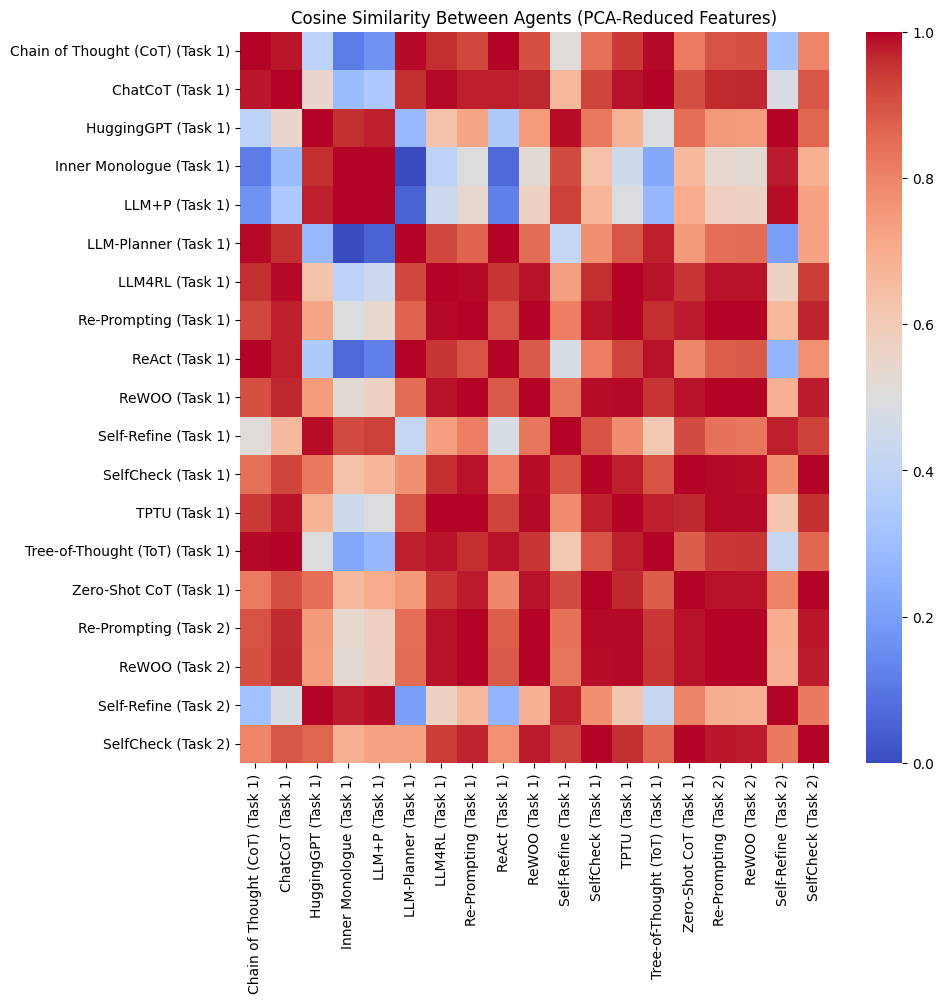

Euclidean Distance Matrix:
[[0.         0.21033089 0.4618391  0.6003041  1.0248488  0.06891824
  0.3085248  0.21639119 0.04532459 0.7997491  0.541665   0.29397294
  0.27675045 0.2097985  0.29000658 0.5101151  0.7997491  0.55137753
  0.46818963]
 [0.21033089 0.         0.5270042  0.6619864  0.9832896  0.27884072
  0.10337661 0.16012245 0.25515088 0.591051   0.5117186  0.24199128
  0.10909048 0.39446047 0.2704827  0.31239742 0.591051   0.5851436
  0.3317784 ]
 [0.4618391  0.5270042  0.         0.13932654 0.62730455 0.46840376
  0.5495303  0.36991906 0.4519208  0.92234683 0.23390986 0.31106433
  0.47438142 0.34259185 0.26905257 0.62940997 0.92234683 0.11080465
  0.44458422]
 [0.6003041  0.6619864  0.13932654 0.         0.54262394 0.603695
  0.6767477  0.5030165  0.58858645 1.0125964  0.2733499  0.4358723
  0.60178345 0.46630722 0.3970827  0.7333661  1.0125964  0.10356293
  0.5369493 ]
 [1.0248488  0.9832896  0.62730455 0.54262394 0.         1.0552074
  0.93979627 0.84152967 1.0319759  1.0

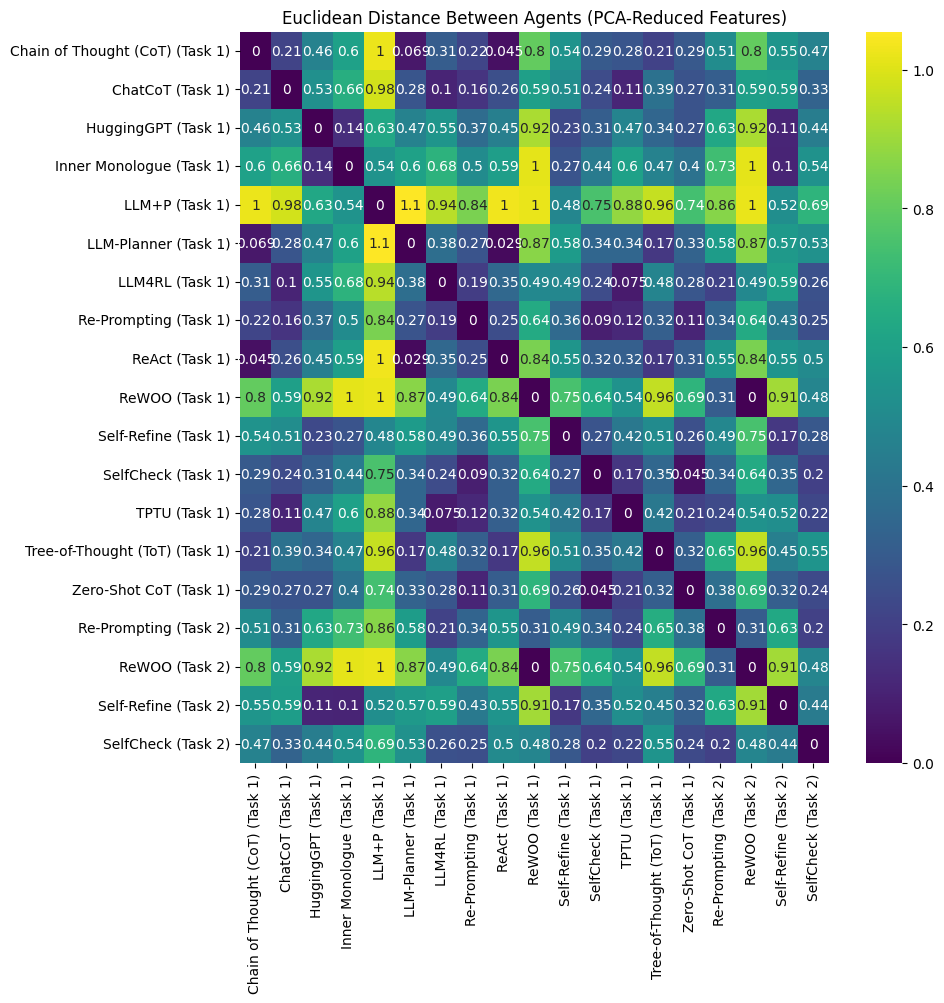

Executing SQL:

    INSERT INTO agent_pair_performance
      (task_name, agent1, agent2, euclidean_distance, cosine_similarity, response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name, agent1, agent2)
    DO UPDATE SET
      euclidean_distance = EXCLUDED.euclidean_distance,
      cosine_similarity = EXCLUDED.cosine_similarity,
      response_length = EXCLUDED.response_length,
      completion_time = EXCLUDED.completion_time;
    
With parameters:
('1', 'Chain of Thought (CoT)', 'Zero-Shot CoT', 0.2900065779685974, 0.8188736438751221, 353.0, 0.0005040168762207031)
✅ Saved performance for task 1 between Chain of Thought (CoT) and Zero-Shot CoT.
Executing SQL:

    INSERT INTO agent_pair_performance
      (task_name, agent1, agent2, euclidean_distance, cosine_similarity, response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name, agent1, agent2)
    DO UPDATE SET
      euclidean_distance = EXCLUDED.eucl

/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/116005420.py:317: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


In [4]:
#Block C: Agent Response Analysis Pipeline: PCA-Driven Task Matrix Construction and Pairwise Performance Evaluation
import psycopg2
import pandas as pd
import numpy as np
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import time

# PostgreSQL connection config
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",
    "host": "localhost",
    "port": 5432
}

embed_model = SentenceTransformer('all-MiniLM-L6-v2')

def fetch_task_responses():
    """
    Retrieve generated responses from the agents table, unnesting the generated_response array.
    """
    with psycopg2.connect(**DB_CONFIG) as conn:
        query = """
        SELECT title, t.response, t.idx
        FROM agents
        CROSS JOIN LATERAL unnest(generated_response) WITH ORDINALITY AS t(response, idx)
        ORDER BY t.idx;
        """
        df = pd.read_sql(query, conn)
    return df

df = fetch_task_responses()
print("✅ Data Fetched Successfully!")
print(df.head())


# ===============================
# 🔹 3) Group Responses by Task (Index)
# ===============================
grouped_responses = defaultdict(dict)  # { idx -> { agent_title: response } }
for _, row in df.iterrows():
    grouped_responses[row['idx']][row['title']] = row['response']

# ===============================
# 🔹 4) Global Encoding: PCA & Normalization
# ===============================
# Extract all responses into a list
all_responses = df["response"].tolist()

# Convert them to embeddings
all_embeddings = embed_model.encode(all_responses, convert_to_numpy=True)

# Optional global minmax scaling
scaler_global = MinMaxScaler()
all_embeddings_scaled = scaler_global.fit_transform(all_embeddings)

# PCA to reduce to 2D
pca_n_components = min(2, all_embeddings_scaled.shape[1])
pca = PCA(n_components=pca_n_components)
pca.fit(all_embeddings_scaled)

pca_embeddings = pca.transform(all_embeddings_scaled)

# (Optional) Another minmax scale after PCA
scaler_pca = MinMaxScaler()
pca_embeddings_scaled = scaler_pca.fit_transform(pca_embeddings)

# ===============================
# 🔹 5) Compute Task Rankings Using Fixed PCA - task_matrix = task_titles and task_responses
# ===============================
# We'll build a task matrix that stores, for each task (idx) and each agent,
# a "Reduced Vector" (the PCA embedding) and a "Total Score" computed as the sum of the absolute values.
task_matrix = defaultdict(dict)
unique_tasks = df["idx"].unique()

for task_id in unique_tasks:
    # Subset to this task
    task_data = df[df["idx"] == task_id]
    task_titles = task_data["title"].tolist()
    task_responses = task_data["response"].tolist()

    # Indices in the all_responses list
    response_indices = [all_responses.index(resp) for resp in task_responses]
    reduced_vectors = pca_embeddings_scaled[response_indices]

    print(f"\n🔹 Task {task_id}: PCA Output Shape = {reduced_vectors.shape}")

    for i, title in enumerate(task_titles):
        if i >= len(reduced_vectors):
            continue
        vector = reduced_vectors[i]

        # For demonstration, total_score = sum(abs(vector))
        total_score = np.sum(np.abs(vector))

        task_matrix[task_id][title] = {
            "Total Score": total_score,
            "Reduced Vector": vector
        }

# (Optional) Remove zero vectors
for tid in list(task_matrix.keys()):
    for agent in list(task_matrix[tid].keys()):
        if np.all(task_matrix[tid][agent]["Reduced Vector"] == 0):
            del task_matrix[tid][agent]


# ===============================
# 🔹 6) Save Task Matrix to CSV
# ===============================
task_matrix_df = pd.DataFrame.from_dict(
    {(t, agent): task_matrix[t][agent] 
     for t in task_matrix.keys() for agent in task_matrix[t].keys()},
    orient='index'
).reset_index()
task_matrix_df.rename(columns={"level_0": "Task", "level_1": "Agent"}, inplace=True)
task_matrix_df.to_csv("normalized_task_matrix_fixed.csv", index=False)
print("✅ Task Matrix CSV saved.")


# ===============================
# 🔹 7) Compute Cosine Similarity & Euclidean Distance & Plot Heatmap
# ===============================
print("\n🔹 Computing Cosine Similarity Between Agents...\n")
valid_vectors = []
valid_agents = []

for task_id in sorted(task_matrix.keys()):
    for agent in sorted(task_matrix[task_id].keys()):
        vector = task_matrix[task_id][agent].get("Reduced Vector", None)
        if vector is not None and np.any(vector):
            valid_agents.append(f"{agent} (Task {task_id})")
            valid_vectors.append(vector)
            print(f"  ✅ {agent} (Task {task_id}): Vector Sum = {np.sum(vector):.4f}")
        else:
            print(f"  ❌ {agent} (Task {task_id}): No valid response")

if len(valid_agents) < 2:
    print("\n⚠️ Not enough valid responses to compute similarity. At least 2 are required.")
else:
    valid_vectors = np.array(valid_vectors)
    similarity_matrix = cosine_similarity(valid_vectors)

    num_agents = len(valid_agents)
    plt.figure(figsize=(min(15, num_agents / 2), min(12, num_agents / 2)))
    sns.heatmap(
        similarity_matrix,
        annot=False,
        cmap="coolwarm",
        xticklabels=valid_agents if num_agents < 40 else valid_agents[::2],
        yticklabels=valid_agents if num_agents < 40 else valid_agents[::2]
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Cosine Similarity Between Agents (PCA-Reduced Features)")
    plt.show()

# After your cosine similarity block, add:

if len(valid_agents) < 2:
    print("\n⚠️ Not enough valid responses to compute Euclidean distances. At least 2 are required.")
else:
    # Compute Euclidean distance matrix using broadcasting:
    euclidean_matrix = np.sqrt(((valid_vectors[:, np.newaxis] - valid_vectors) ** 2).sum(axis=2))
    
    # Print the Euclidean matrix for inspection
    print("Euclidean Distance Matrix:")
    print(euclidean_matrix)
    
    # Plot the Euclidean distance matrix as a heatmap.
    plt.figure(figsize=(min(15, num_agents / 2), min(12, num_agents / 2)))
    sns.heatmap(
        euclidean_matrix,
        annot=True,  # Set to True to display distance values on the heatmap
        cmap="viridis",  # You can choose another colormap if preferred
        xticklabels=valid_agents if num_agents < 40 else valid_agents[::2],
        yticklabels=valid_agents if num_agents < 40 else valid_agents[::2]
    )
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.title("Euclidean Distance Between Agents (PCA-Reduced Features)")
    plt.show()



# ===============================
# 🔹 6) Compute Pair Performance
# ===============================
def compute_pair_performance(vector1, vector2, response1, response2):
    """
    Computes performance metrics for a pair of responses:
      - euclidean_distance: L2 norm between the two vectors.
      - cosine_similarity: Cosine similarity between the two vectors.
      - response_length: Average length of the two responses.
      - completion_time: Time taken to compute these metrics.
    """
    start_time = time.time()
    euclidean_distance = np.linalg.norm(vector1 - vector2)
    cos_sim = cosine_similarity([vector1], [vector2])[0][0]
    avg_response_length = (len(response1) + len(response2)) / 2.0
    completion_time = time.time() - start_time

    return {
        "euclidean_distance": float(euclidean_distance),
        "cosine_similarity": float(cos_sim),
        "response_length": float(avg_response_length),
        "completion_time": float(completion_time)
    }

# ===============================
# 🔹 Save Agent Pair Performance
# ===============================
def save_pair_performance(task_name, agent1, agent2, performance):
    """
    Saves performance metrics for an agent pair into the agent_pair_performance table.
    Assumes that (task_name, agent1, agent2) is unique.
    """
    insert_sql = """
    INSERT INTO agent_pair_performance
      (task_name, agent1, agent2, euclidean_distance, cosine_similarity, response_length, completion_time)
    VALUES (%s, %s, %s, %s, %s, %s, %s)
    ON CONFLICT (task_name, agent1, agent2)
    DO UPDATE SET
      euclidean_distance = EXCLUDED.euclidean_distance,
      cosine_similarity = EXCLUDED.cosine_similarity,
      response_length = EXCLUDED.response_length,
      completion_time = EXCLUDED.completion_time;
    """
    params = (
        str(task_name),
        agent1,
        agent2,
        float(performance["euclidean_distance"]),
        float(performance["cosine_similarity"]),
        float(performance["response_length"]),
        float(performance["completion_time"])
    )
    print("Executing SQL:")
    print(insert_sql)
    print("With parameters:")
    print(params)
    
    with psycopg2.connect(**DB_CONFIG, cursor_factory=LoggingCursor) as conn:
        with conn.cursor() as cursor:
            cursor.execute(insert_sql, params)
        conn.commit()
    print(f"✅ Saved performance for task {task_name} between {agent1} and {agent2}.")


def process_pair_performance(grouped_responses, task_matrix):
    """
    Loops over each task iteration and for each unique pair of agents in that task,
    computes performance metrics and saves them to the agent_pair_performance table.
    """
    for task_id in sorted(grouped_responses.keys()):
        responses_dict = grouped_responses[task_id]  # {agent_title: response}
        agents = list(responses_dict.keys())
        # Ensure at least two agents provided a response.
        if len(agents) < 2:
            continue
        for i in range(len(agents)):
            for j in range(i + 1, len(agents)):
                agent1 = agents[i]
                agent2 = agents[j]
                # Retrieve PCA-reduced vectors from task_matrix.
                if agent1 in task_matrix[task_id] and agent2 in task_matrix[task_id]:
                    vector1 = task_matrix[task_id][agent1]["Reduced Vector"]
                    vector2 = task_matrix[task_id][agent2]["Reduced Vector"]
                    response1 = responses_dict[agent1]
                    response2 = responses_dict[agent2]
                    
                    performance = compute_pair_performance(vector1, vector2, response1, response2)
                    save_pair_performance(task_id, agent1, agent2, performance)
                else:
                    print(f"❌ Missing reduced vector for {agent1} or {agent2} in task {task_id}")

# ===============================
# 🔹 7) Loop Over Each Task Iteration and Compute Pairwise Performance
# ===============================
for task_id in sorted(grouped_responses.keys()):
    responses_dict = grouped_responses[task_id]  # {agent_title: response}
    agents = list(responses_dict.keys())
    # Ensure at least two agents provided a response for this task.
    if len(agents) < 2:
        continue
    # Loop over all unique pairs of agents.
    for i in range(len(agents)):
        for j in range(i + 1, len(agents)):
            agent1 = agents[i]
            agent2 = agents[j]
            # Retrieve PCA-reduced vectors from your task_matrix.
            # (Ensure that agent names in task_matrix match those in grouped_responses.)
            if agent1 in task_matrix[task_id] and agent2 in task_matrix[task_id]:
                vector1 = task_matrix[task_id][agent1]["Reduced Vector"]
                vector2 = task_matrix[task_id][agent2]["Reduced Vector"]
                response1 = responses_dict[agent1]
                response2 = responses_dict[agent2]
                
                performance = compute_pair_performance(vector1, vector2, response1, response2)
                save_pair_performance(task_id, agent1, agent2, performance)
            else:
                print(f"❌ Missing reduced vector for {agent1} or {agent2} in task {task_id}")

# ===============================
# 🔹 8) Display Stored Performance Tables
# ===============================
# Connect to the database and read the agent_pair_performance table into a DataFrame.
with psycopg2.connect(**DB_CONFIG) as conn:
    df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Table:")
print(df_agent_pair)

<!-- block_d.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block D: Visualizing Agent Pair Performance for a single task: Heatmap Analysis of Euclidean and Cosine Metrics**  

Block 1 – Database Connection Config  
•	Imports the psycopg2 module along with other necessary libraries.  
•	Defines the DB_CONFIG dictionary with keys for database name, user, password, host, and port.

Block 2 – Fetch Data from Database  
•	Retrieve all rows from the agent_pair_performance table.  
•	Uses a with statement to open a database connection via psycopg2.connect(**DB_CONFIG).  
•	Executes a SQL query to select all data from the agent_pair_performance table, ordering the results by task name and the names of the agent pairs.  
•	Loads the results into a pandas DataFrame (df_agent_pair).

Block 3 – Filter Data by Task  
•	Isolate the performance metrics for a specific task.  
•	Defines a task identifier (e.g., task_id = '1').  
•	Filters the DataFrame to only include rows corresponding to the selected task.  
•	Checks if the filtered DataFrame is empty, ensuring that there is data to visualize.  
•	Note: Instead of defining the task_id we can loop over and continue for next task.

Block 4 – Pivot Data for Heatmaps  
•	Reshape the data for effective visualization.  
•	Uses the pivot function in pandas to create two matrices:  
  o	Euclidean Matrix: Rows represent agent1, columns represent agent2, and values are the Euclidean distances.  
  o	Cosine Matrix: Similarly, rows represent agent1, columns represent agent2, and values are the cosine similarities.

Block 5 – Plot the Heatmaps  
•	Visualize the pair performance metrics for easy analysis.  
•	Uses matplotlib and seaborn to create two heatmaps:  
  o	One heatmap displays the Euclidean distance matrix.  
  o	The other heatmap displays the cosine similarity matrix.  
•	Sets figure size, titles, axis labels, and rotations to ensure the plots are clear and informative.

  
**Overall Summary: Block D**  
•	Data Extraction & Preparation:  
The script connects to the PostgreSQL database using predefined credentials, fetches agent pair performance data, and filters it for a specific task.  
•	Data Reshaping:  
The data is pivoted into two matrices—one for Euclidean distances and another for cosine similarities—making it ready for visualization.  
•	Visualization:  
The heatmaps generated provide an intuitive visual summary of the relationships between agents' performance metrics, supporting further analysis of agent behavior and response similarity.
</div>


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/3008327430.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.210331   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.461839   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.600304   
3  13         1  Chain of Thought (CoT)            LLM+P            1.024849   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.068918   

   cosine_similarity  response_length  completion_time  \
0           0.983470            353.0         0.000374   
1           0.389318            353.0         0.000303   
2           0.113203            353.0         0.000362   
3           0.166643            353.0         0.000351   
4           0.993572            353.0         0.000346   

                   timestamp  
0 2025-03-04 17:29:53.142186  
1 2025-03-04 17:29:53.169755  
2 2025-03-04 17:29:53.194068  


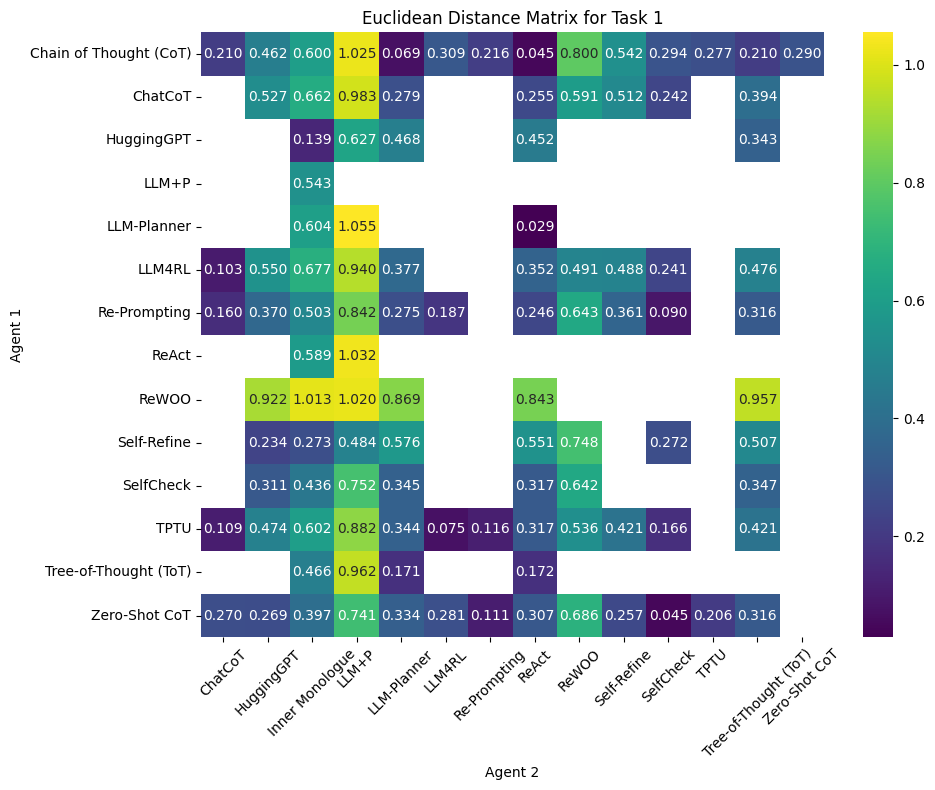

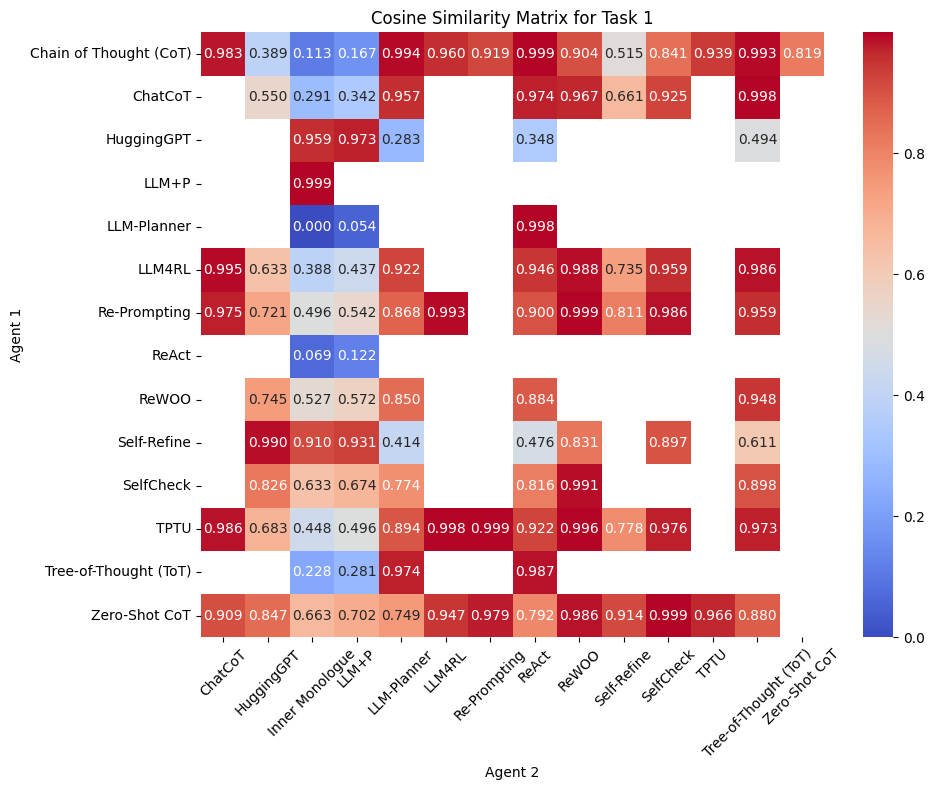

In [5]:
#Block D: Visualizing Agent Pair Performance for a single task: Heatmap Analysis of Euclidean and Cosine Metrics
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch Data from Database
# -------------------------------
# Connect to the database and fetch all rows from the agent_pair_performance table.
with psycopg2.connect(**DB_CONFIG) as conn:
    df_agent_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_agent_pair.head())

# -------------------------------
# 3) Filter Data by Task
# -------------------------------
# Choose a task to visualize. For example, we use task "1".
task_id = '1'
df_task = df_agent_pair[df_agent_pair['task_name'] == task_id]

if df_task.empty:
    print(f"No data found for task {task_id}.")
else:
    # -------------------------------
    # 4) Pivot Data for Heatmaps
    # -------------------------------
    # Pivot the table so that rows represent agent1 and columns represent agent2.
    euclidean_matrix = df_task.pivot(index='agent1', columns='agent2', values='euclidean_distance')
    cosine_matrix = df_task.pivot(index='agent1', columns='agent2', values='cosine_similarity')

    print("\nEuclidean Distance Matrix for Task", task_id)
    print(euclidean_matrix)
    print("\nCosine Similarity Matrix for Task", task_id)
    print(cosine_matrix)

    # -------------------------------
    # 5) Plot the Heatmaps
    # -------------------------------
    plt.figure(figsize=(10, 8))
    sns.heatmap(euclidean_matrix, annot=True, fmt=".3f", cmap="viridis")
    plt.title(f"Euclidean Distance Matrix for Task {task_id}")
    plt.xlabel("Agent 2")
    plt.ylabel("Agent 1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(cosine_matrix, annot=True, fmt=".3f", cmap="coolwarm")
    plt.title(f"Cosine Similarity Matrix for Task {task_id}")
    plt.xlabel("Agent 2")
    plt.ylabel("Agent 1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


<!-- block_e.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block E: Agent-Level Aggregated Metrics for Euclidean Distance and Cosine Similarity**  

Block 1 - Database Connection & Data Retrieval  
•	The script first sets up the database connection using the provided configuration (DB_CONFIG).  
•	It then runs an SQL query to fetch all records from the agent_pair_performance table, ordering them by task_name, agent1, and agent2.  
•	The result is loaded into a pandas DataFrame (df_pair), and the first few rows are printed for verification.

Block 2 - Preparing Data for Average Euclidean Distance  
•	Two subsets of the DataFrame are created:  
  o	One (df_agent1) contains columns task_name, agent1, and euclidean_distance (with agent1 renamed to agent).  
  o	Another (df_agent2) does the same for agent2.  
•	These two DataFrames are concatenated vertically, resulting in a DataFrame (df_agents) where each row represents an agent (regardless of whether it was agent1 or agent2) along with its corresponding Euclidean distance.  
•	The data is then grouped by task_name and agent, and the mean Euclidean distance is calculated, yielding df_avg_ed.

Block 3 - Pivoting Data for Euclidean Distance Plotting  
•	The grouped DataFrame df_avg_ed is pivoted so that each row represents a task, each column represents an agent, and the cell values are the average Euclidean distances.  
•	This pivoted DataFrame is printed for inspection.

Block 4 - Plotting the Euclidean Distance Scatter Plot  
•	A scatter plot is created by iterating over each agent (each column in the pivoted DataFrame).  
•	For each agent, tasks (i.e., task names) where that agent has an average Euclidean distance value are plotted.  
•	The plot is formatted with axis labels, a title, a legend, and rotated x-ticks for clarity, then displayed.

Block 5 - Preparing Data for Average Cosine Similarity  
•	The same process is repeated for cosine similarity:  
  o	Two subsets (df_agent1 and df_agent2) are extracted from df_pair, this time for the cosine_similarity column.  
  o	These are concatenated into a single DataFrame.  
  o	The data is grouped by task_name and agent to compute the average cosine similarity for each agent, producing df_avg_cosine.

Block 6 - Pivoting Data for Cosine Similarity Plotting  
•	The grouped DataFrame df_avg_cosine is pivoted so that rows represent tasks and columns represent agents, with average cosine similarity values as the data.  
•	The pivoted data is printed.

Block 7 - Plotting the Cosine Similarity Scatter Plot  
•	A scatter plot is generated for cosine similarity by iterating over each agent column from the pivoted DataFrame.  
•	Each agent’s average cosine similarity across tasks is plotted.  
•	The plot includes labels, a title, and a legend, then is displayed.

  
**Overall Summary: Block E**  
•	Rows are duplicated for agent1 and agent2, allowing per-agent metrics rather than strictly pairwise.  
•	Pivoting creates a tasks-by-agents matrix for both ED and cosine similarity.  
•	Scatter plots make it easy to compare each agent’s metrics across multiple tasks.
</div>


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.210331   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.461839   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.600304   
3  13         1  Chain of Thought (CoT)            LLM+P            1.024849   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.068918   

   cosine_similarity  response_length  completion_time  \
0           0.983470            353.0         0.000374   
1           0.389318            353.0         0.000303   
2           0.113203            353.0         0.000362   
3           0.166643            353.0         0.000351   
4           0.993572            353.0         0.000346   

                   timestamp  
0 2025-03-04 17:29:53.142186  
1 2025-03-04 17:29:53.169755  
2 2025-03-04 17:29:53.194068  


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/945583076.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


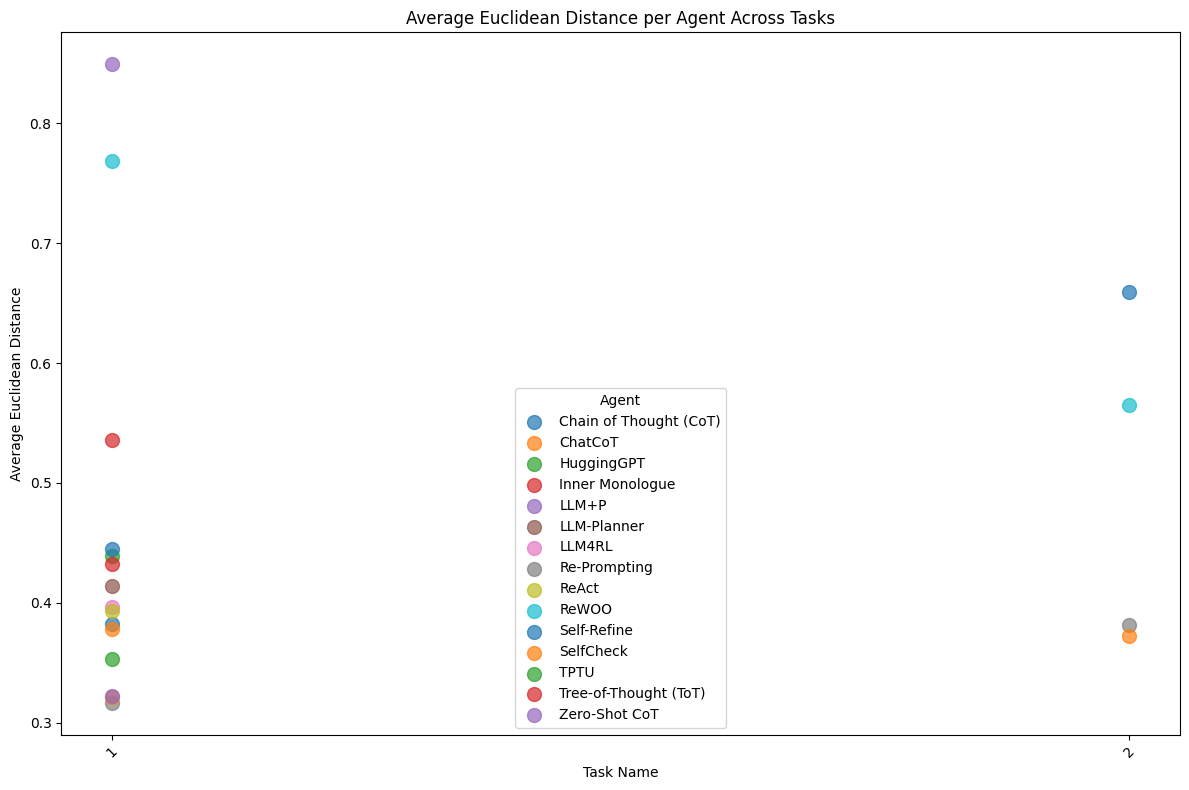

/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_59551/945583076.py:91: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.210331   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.461839   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.600304   
3  13         1  Chain of Thought (CoT)            LLM+P            1.024849   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.068918   

   cosine_similarity  response_length  completion_time  \
0           0.983470            353.0         0.000374   
1           0.389318            353.0         0.000303   
2           0.113203            353.0         0.000362   
3           0.166643            353.0         0.000351   
4           0.993572            353.0         0.000346   

                   timestamp  
0 2025-03-04 17:29:53.142186  
1 2025-03-04 17:29:53.169755  
2 2025-03-04 17:29:53.194068  


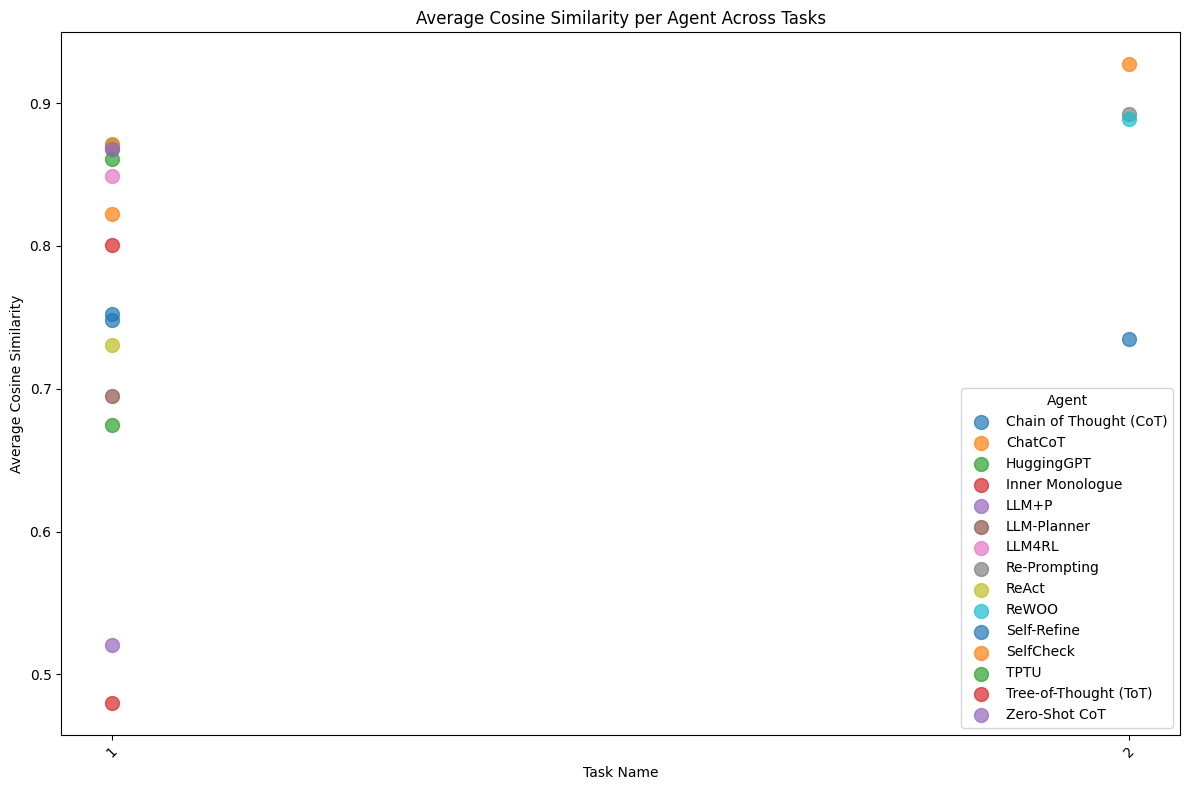

In [ ]:
#Block E: Agent-Level Aggregated Metrics for Euclidean Distance and Cosine Similarity
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch agent_pair_performance Data from DB
# -------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_pair.head())

# -------------------------------
# 3) Prepare Data for Agent-Level Average ED Calculation
# -------------------------------
# For each pair (agent1, agent2) in a task, we want to assign the ED to both agents.
# Duplicate each row for agent1 and agent2.
df_agent1 = df_pair[['task_name', 'agent1', 'euclidean_distance']].rename(columns={'agent1': 'agent'})
df_agent2 = df_pair[['task_name', 'agent2', 'euclidean_distance']].rename(columns={'agent2': 'agent'})
df_agents = pd.concat([df_agent1, df_agent2], ignore_index=True)

# Now, group by task_name and agent to compute the average Euclidean distance for that agent.
df_avg_ed = df_agents.groupby(['task_name', 'agent'], as_index=False)['euclidean_distance'].mean()
df_avg_ed.rename(columns={'euclidean_distance': 'avg_euclidean_distance'}, inplace=True)

print("\nAverage Euclidean Distance per Agent per Task:")
print(df_avg_ed.head())

# -------------------------------
# 4) Pivot Data for Plotting
# -------------------------------
# Pivot so that rows = task_name and columns = agent names with the average ED as values.
df_pivot = df_avg_ed.pivot(index='task_name', columns='agent', values='avg_euclidean_distance')
print("\nPivoted Data (tasks x agents):")
print(df_pivot.head())

# -------------------------------
# 5) Plotting: Scatter Plot of Average ED for Each Agent Across Tasks
# -------------------------------
plt.figure(figsize=(12, 8))

# For each agent (i.e. each column in the pivoted DataFrame), plot its average ED across tasks.
for agent in df_pivot.columns:
    # Drop tasks where the agent does not have a value
    task_vals = df_pivot[agent].dropna()
    plt.scatter(task_vals.index, task_vals.values, label=agent, s=100, alpha=0.7)

plt.xlabel('Task Name')
plt.ylabel('Average Euclidean Distance')
plt.title('Average Euclidean Distance per Agent Across Tasks')
plt.legend(title="Agent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch agent_pair_performance Data from DB
# -------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_pair.head())

# -------------------------------
# 3) Prepare Data for Agent-Level Average Cosine Similarity Calculation
# -------------------------------
# Duplicate each row so that both agent1 and agent2 get the cosine similarity value.
df_agent1 = df_pair[['task_name', 'agent1', 'cosine_similarity']].rename(columns={'agent1': 'agent'})
df_agent2 = df_pair[['task_name', 'agent2', 'cosine_similarity']].rename(columns={'agent2': 'agent'})
df_agents = pd.concat([df_agent1, df_agent2], ignore_index=True)

# Group by task_name and agent, computing the mean cosine similarity for each agent.
df_avg_cosine = df_agents.groupby(['task_name', 'agent'], as_index=False)['cosine_similarity'].mean()
df_avg_cosine.rename(columns={'cosine_similarity': 'avg_cosine_similarity'}, inplace=True)

print("\nAverage Cosine Similarity per Agent per Task:")
print(df_avg_cosine.head())

# -------------------------------
# 4) Pivot Data for Plotting
# -------------------------------
# Pivot the data so that each row is a task and each column is an agent.
df_pivot_cosine = df_avg_cosine.pivot(index='task_name', columns='agent', values='avg_cosine_similarity')
print("\nPivoted Data (tasks x agents) for Cosine Similarity:")
print(df_pivot_cosine.head())

# -------------------------------
# 5) Plotting: Scatter Plot of Average Cosine Similarity for Each Agent Across Tasks
# -------------------------------
plt.figure(figsize=(12, 8))
for agent in df_pivot_cosine.columns:
    # Drop tasks where the agent does not have a value
    task_vals = df_pivot_cosine[agent].dropna()
    plt.scatter(task_vals.index, task_vals.values, label=agent, s=100, alpha=0.7)

plt.xlabel('Task Name')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity per Agent Across Tasks')
plt.legend(title="Agent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<!-- block_f.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block F: Agent-Level Aggregated Metrics for Euclidean Distance and Cosine Similarity**  

Block 1 - Database Connection & Data Retrieval:  
•	The script uses psycopg2 to connect to the PostgreSQL database configured in DB_CONFIG.  
•	It executes an SQL query to select all rows from the agent_pair_performance table where task_name is '1'.  
•	The fetched data is ordered by task_name, agent1, and agent2 and then loaded into a pandas DataFrame named df_task1.  
•	The first few rows of df_task1 are printed for verification.

Block 2 - Prepare Features for Clustering:  
•	The code defines a list of features that will be used for clustering: euclidean_distance, cosine_similarity, response_length, and completion_time.  
•	It extracts these columns from df_task1 as a NumPy array (X).  
•	StandardScaler is then applied to X to normalize the data, ensuring that each metric contributes equally to the clustering process. The scaled features are stored in X_scaled.

Block 3 - Perform KMeans Clustering:  
•	The number of clusters is set to 3 (k=3).  
•	KMeans is applied to the scaled feature matrix (X_scaled), and each row in df_task1 receives a cluster assignment stored in a new column named cluster.  
•	The cluster assignments are printed to show which agent pairs fall into each cluster.

Block 4 - Dimensionality Reduction with PCA for Visualization:  
•	PCA is used to reduce the high-dimensional, scaled feature space to 2 dimensions so that the clustering results can be visualized on a 2D plot.  
•	The resulting two principal components are added to df_task1 as columns pca1 and pca2.

Block 5 - Plot the Clustering Results:  
•	A scatter plot is created using matplotlib and seaborn.  
•	The x- and y-axes represent the first and second PCA components, respectively.  
•	Points in the scatter plot are colored according to their cluster assignments.  
•	Each point is annotated with the corresponding agent pair (formatted as “agent1 vs agent2”).  
•	The plot is formatted with a title, axis labels, a legend, and rotated x-ticks for readability, then is displayed.

  
**Overall Summary: Block F**  
•	Retrieves performance data for a specific task (e.g., task_name='1') from a PostgreSQL database.  
•	Selects four features for clustering: Euclidean distance, cosine similarity, response length, and completion time.  
•	Applies data scaling (StandardScaler) to normalize the features.  
•	Performs KMeans clustering with three clusters (k=3) on the scaled data.  
•	Uses PCA to reduce dimensionality to two principal components for visualization.  
•	Plots a 2D scatter chart with points colored by cluster and annotated with agent pair labels.
</div>


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_51871/2068513451.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_task1 = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Task 1 Agent Pair Performance Data:
   id task_name                  agent1         agent2  euclidean_distance  \
0   1         1  Chain of Thought (CoT)  Zero-Shot CoT            0.189377   
1   2         1  Chain of Thought (CoT)           TPTU            0.648624   
2   3         1  Chain of Thought (CoT)   Re-Prompting            0.055284   
3   4         1  Chain of Thought (CoT)         LLM4RL            0.223621   
4   5         1  Chain of Thought (CoT)        ChatCoT            0.117625   

   cosine_similarity  response_length  completion_time  \
0           0.997355            353.0         0.000426   
1           0.788011            353.0         0.000361   
2           0.996217            353.0         0.000524   
3           0.994825            353.0         0.000318   
4           0.985111            353.0         0.000180   

                   timestamp  
0 2025-02-24 20:37:03.292818  
1 2025-02-24 20:37:03.306733  
2 2025-02-24 20:37:03.319394  
3 2025-02-24 20:37:03.

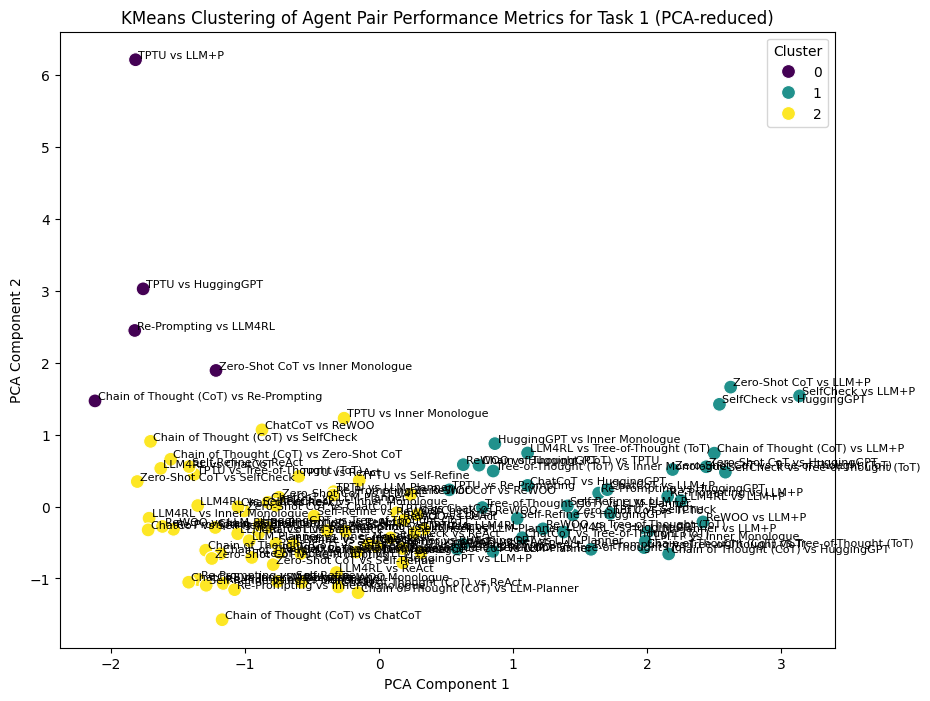

In [ ]:
#Block F: Agent-Level Aggregated Metrics for Euclidean Distance and Cosine Similarity
import psycopg2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1) Database Connection Config
# -------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# -------------------------------
# 2) Fetch Task 1 Agent Pair Performance Data
# -------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_task1 = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)

print("Task 1 Agent Pair Performance Data:")
print(df_task1.head())

# -------------------------------
# 3) Prepare Features for Clustering 
# -------------------------------
# Use the remaining performance metrics as features.
features = ['euclidean_distance', 'cosine_similarity', 'response_length', 'completion_time']
X = df_task1[features].values

# Scale the features so that each metric contributes equally.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -------------------------------
# 4) Perform KMeans Clustering
# -------------------------------
# Choose the number of clusters; for example, k=3.
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
df_task1['cluster'] = kmeans.fit_predict(X_scaled)

print("\nCluster assignments:")
print(df_task1[['task_name', 'agent1', 'agent2', 'cluster']])

# -------------------------------
# 5) Dimensionality Reduction with PCA for Visualization
# -------------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_task1['pca1'] = X_pca[:, 0]
df_task1['pca2'] = X_pca[:, 1]

# -------------------------------
# 6) Plot the Clustering Results
# -------------------------------
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_task1, x='pca1', y='pca2', hue='cluster', palette='viridis', s=100)

# Annotate each point with the agent pair names.
for idx, row in df_task1.iterrows():
    label = f"{row['agent1']} vs {row['agent2']}"
    plt.text(row['pca1'] + 0.02, row['pca2'] + 0.02, label, fontsize=8)

plt.title("KMeans Clustering of Agent Pair Performance Metrics for Task 1 (PCA-reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


<!-- block_g.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block G: KMeans Clustering with Planning Taxonomy**  

Block 1 – Database Connection Config  
•	Sets Up the Database Connection  
A DB_CONFIG dictionary defines the credentials (dbname, user, password, host, port). psycopg2.connect(**DB_CONFIG) uses these credentials to connect to the PostgreSQL database.

Block 2 – Define the Planning Taxonomy  
•	Organizes Agents by Subcategory  
A nested dictionary (PLANNING_AGENTS) maps high-level planning categories to subcategories and agent names. A loop creates a dictionary agent_to_subcat that links each agent’s title to its subcategory.

Block 3 – Fetch agent_pair_performance Data from DB  
•	Retrieves Agent-Pair Metrics  
A SQL query selects all rows from agent_pair_performance, ordered by task_name, agent1, agent2. The results load into a DataFrame (df_pair), and a preview is printed to confirm successful retrieval.

Block 4 – Add Planning Taxonomy Labels  
•	Labels Each Pair with Subcategories  
Two new columns, agent1_subcat and agent2_subcat, match each agent to its taxonomy label using agent_to_subcat.  
  o	A function combine_subcats merges these labels in sorted order to form pair_category (e.g., "Single-Path Reasoning–Multi-Path Reasoning").

Block 5 – Prepare Features for Clustering  
•	Selects and Scales Key Metrics  
A set of four performance metrics—euclidean_distance, cosine_similarity, response_length, and completion_time—are extracted from df_pair.  
  o	These features are stored in X (a NumPy array).  
  o	StandardScaler normalizes X, producing X_scaled for fair comparison between metrics of different scales.

Block 6 – Perform KMeans Clustering  
•	Groups Similar Agent Pairs  
A KMeans model (with k=5 clusters) is fit to X_scaled. The predicted cluster ID for each row is assigned to a new column cluster in df_pair. The script then prints out some cluster assignments for verification.

Block 7 – Dimensionality Reduction with PCA for Visualization  
•	Condenses Metrics into Two Principal Components  
PCA (with n_components=2) transforms the scaled features (X_scaled) into X_pca.  
  o	The resulting two PCA dimensions are stored as pca1 and pca2 in df_pair, making the data ready for 2D plotting.

Block 8 – Plot the Clustering Results  
•	Visualizes Clusters in PCA Space  
A scatter plot uses the PCA components on the x- and y-axes.  
  o	Points are colored by the combined subcategory label (pair_category) and further styled by the cluster ID.  
  o	Each point is annotated with the agent pair names (e.g., “agent1 vs agent2”).  
  o	The figure includes titles, axis labels, legends, and layout adjustments for clarity.

Block 9 – Print the Final DataFrame  
•	Inspects the Outcome  
Finally, the script prints the updated DataFrame (df_pair) with columns for subcategories, cluster assignments, and PCA components, providing a full view of the processed data.

  
**Overall Summary: Block G**  
1.	Planning Taxonomy Integration: A nested dictionary (PLANNING_AGENTS) defines subcategories for various agents (e.g., Single-Path vs. Multi-Path Reasoning). Each pair of agents is then labeled with a combined category.  
2.	Feature Selection & Scaling: Four metrics—Euclidean distance, cosine similarity, response length, and completion time—are extracted from the agent_pair_performance table and standardized via StandardScaler.  
3.	KMeans Clustering: With k=5, the script groups agent pairs into clusters based on their scaled performance features, assigning each row to a cluster.  
4.	PCA Dimensionality Reduction: The high-dimensional feature space is reduced to two principal components, making it possible to visualize each pair’s cluster on a 2D scatter plot.  
5.	Final Visualization: Points are annotated by agent pair names, colored by subcategory, and styled by cluster, offering a detailed view of how different planning approaches cluster together.
</div>


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_51871/2962837478.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)


Agent Pair Performance Data (first few rows):
   id task_name                  agent1           agent2  euclidean_distance  \
0   5         1  Chain of Thought (CoT)          ChatCoT            0.117625   
1   9         1  Chain of Thought (CoT)       HuggingGPT            0.959710   
2  14         1  Chain of Thought (CoT)  Inner Monologue            0.193068   
3  13         1  Chain of Thought (CoT)            LLM+P            0.733446   
4  11         1  Chain of Thought (CoT)      LLM-Planner            0.492770   

   cosine_similarity  response_length  completion_time  \
0           0.985111            353.0         0.000180   
1           0.735720            353.0         0.000198   
2           0.986706            353.0         0.000278   
3           0.457910            353.0         0.000330   
4           0.975310            353.0         0.000198   

                   timestamp  
0 2025-02-24 20:37:03.333899  
1 2025-02-24 20:37:03.365435  
2 2025-02-24 20:37:03.393174  


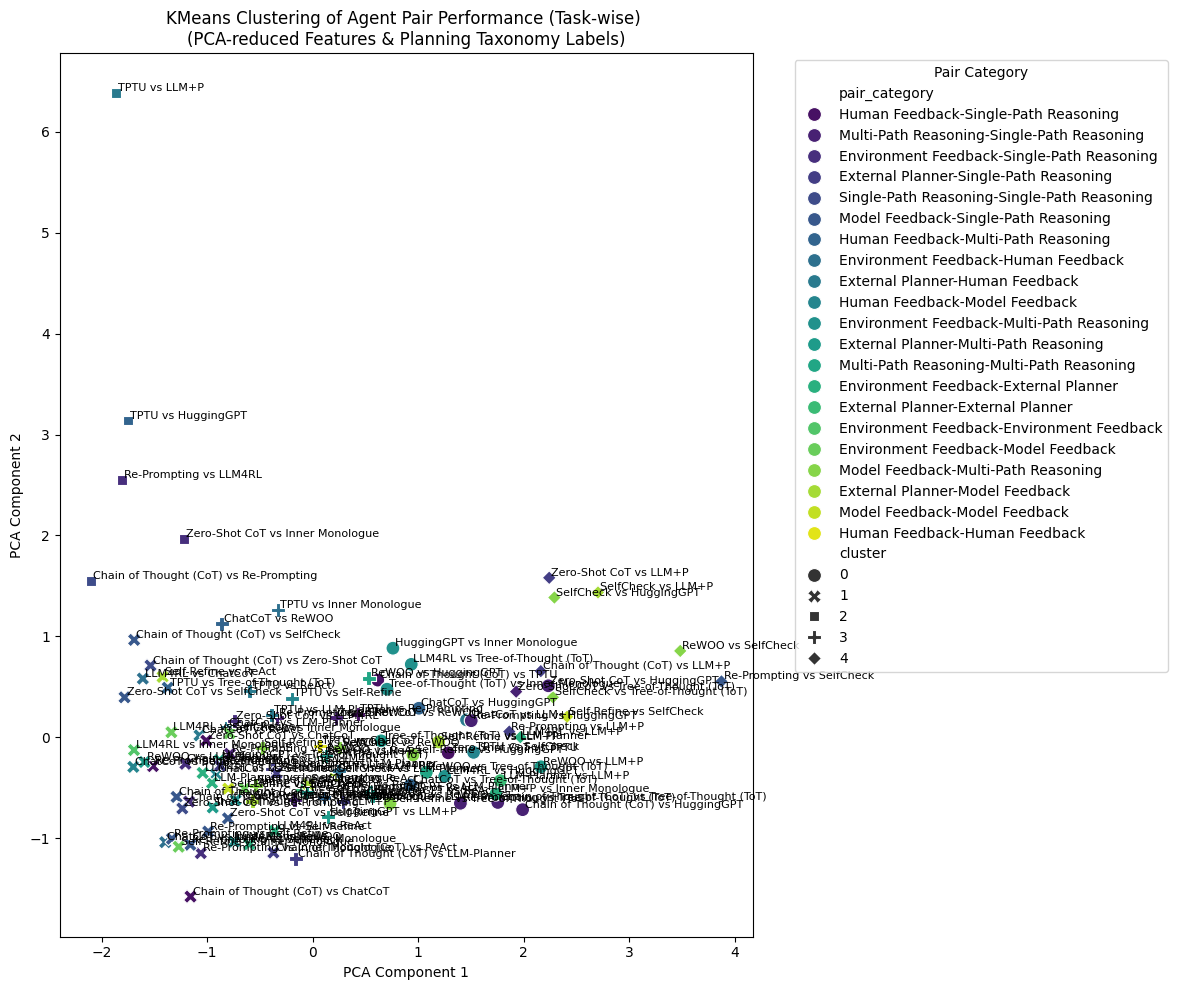


Final Agent Pair Performance with Clusters and Labels:
    id task_name                  agent1                 agent2  \
0    5         1  Chain of Thought (CoT)                ChatCoT   
1    9         1  Chain of Thought (CoT)             HuggingGPT   
2   14         1  Chain of Thought (CoT)        Inner Monologue   
3   13         1  Chain of Thought (CoT)                  LLM+P   
4   11         1  Chain of Thought (CoT)            LLM-Planner   
5    4         1  Chain of Thought (CoT)                 LLM4RL   
6    3         1  Chain of Thought (CoT)           Re-Prompting   
7   12         1  Chain of Thought (CoT)                  ReAct   
8    8         1  Chain of Thought (CoT)                  ReWOO   
9    6         1  Chain of Thought (CoT)            Self-Refine   
10   7         1  Chain of Thought (CoT)              SelfCheck   
11   2         1  Chain of Thought (CoT)                   TPTU   
12  10         1  Chain of Thought (CoT)  Tree-of-Thought (ToT)   
13   1

In [ ]:
#Block G: KMeans Clustering with Planning Taxonomy
import psycopg2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity

# ---------------------------
# 1) Database Connection Config
# ---------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# ---------------------------
# 2) Define the Planning Taxonomy (as in your code)
# ---------------------------
PLANNING_AGENTS = {
    "Planning Without Feedback": {
        "Single-Path Reasoning": ["Chain of Thought (CoT)", "Zero-Shot CoT", "Re-Prompting"],
        "Multi-Path Reasoning": ["ReWOO", "HuggingGPT", "Tree-of-Thought (ToT)"],
        "External Planner": ["LLM-Planner", "ReAct", "LLM+P"]
    },
    "Planning With Feedback": {
        "Environment Feedback": ["Inner Monologue", "LLM4RL"],
        "Human Feedback": ["ChatCoT", "TPTU"],
        "Model Feedback": ["Self-Refine", "SelfCheck"]
    }
}

# Create a mapping from agent title to its planning sub-category.
agent_to_subcat = {}
for planning_group in PLANNING_AGENTS.values():
    for subcat, agents in planning_group.items():
        for agent in agents:
            agent_to_subcat[agent] = subcat

# ---------------------------
# 3) Fetch agent_pair_performance Data from DB
# ---------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance ORDER BY task_name, agent1, agent2;", conn)

print("Agent Pair Performance Data (first few rows):")
print(df_pair.head())

# ---------------------------
# 4) Add Planning Taxonomy Labels
# ---------------------------
# Map agent1 and agent2 to their subcategories.
df_pair['agent1_subcat'] = df_pair['agent1'].map(agent_to_subcat)
df_pair['agent2_subcat'] = df_pair['agent2'].map(agent_to_subcat)

# Create a combined label (sorted alphabetically so that "A-B" is the same as "B-A")
def combine_subcats(row):
    cats = sorted([str(row['agent1_subcat']), str(row['agent2_subcat'])])
    return "-".join(cats)

df_pair['pair_category'] = df_pair.apply(combine_subcats, axis=1)
print("\nData with Planning Labels:")
print(df_pair[['task_name', 'agent1', 'agent1_subcat', 'agent2', 'agent2_subcat', 'pair_category']].head())

# ---------------------------
# 5) Prepare Features for Clustering 
# ---------------------------
# We use these performance metrics as features.
features = ['euclidean_distance', 'cosine_similarity', 'response_length', 'completion_time']
X = df_pair[features].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 6) Perform KMeans Clustering
# ---------------------------
# Choose the number of clusters; for example, k=3.
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
df_pair['cluster'] = kmeans.fit_predict(X_scaled)
print("\nCluster assignments (first few rows):")
print(df_pair[['task_name', 'agent1', 'agent2', 'cluster']].head())

# ---------------------------
# 7) Dimensionality Reduction with PCA for Visualization
# ---------------------------
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
df_pair['pca1'] = X_pca[:, 0]
df_pair['pca2'] = X_pca[:, 1]

# ---------------------------
# 8) Plot the Clustering Results
# ---------------------------
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df_pair, x='pca1', y='pca2', hue='pair_category', style='cluster', palette='viridis', s=100)

# Annotate each point with the agent pair names.
for idx, row in df_pair.iterrows():
    label = f"{row['agent1']} vs {row['agent2']}"
    plt.text(row['pca1'] + 0.02, row['pca2'] + 0.02, label, fontsize=8)

plt.title("KMeans Clustering of Agent Pair Performance (Task-wise) \n(PCA-reduced Features & Planning Taxonomy Labels)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Pair Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---------------------------
# 9) (Optional) Print the final DataFrame for inspection
# ---------------------------
print("\nFinal Agent Pair Performance with Clusters and Labels:")
print(df_pair.head(20))


<!-- block_h.md -->
<style>
  .medium-text { font-size: 16px; }
  .text-block { line-height: 1.5; }
</style>

<div class="medium-text text-block">
**Block H: Complexity Factor–Based Agent Performance Analysis for Task 1**  

Block 1 – Database Connection Configuration  
•	A DB_CONFIG dictionary specifies the connection details (dbname, user, password, host, port).  
•	psycopg2.connect(**DB_CONFIG) uses these credentials to query the agent_pair_performance table for task_name = '1'.  
•	The results load into a DataFrame (df_pair), and the first few rows are printed to confirm successful data retrieval.

Block 2 – Define Complexity Mapping  
•	A dictionary, complexity_mapping, assigns each agent a numerical “complexity” rating (lower is better).  
•	Agents not found in the dictionary default to a higher complexity value (e.g., 10).  
•	This rating is used to identify which agent’s approach is the “least complex.”

Block 3 – Fetch agent_pair_performance Data for Task 1  
•	Already done in the previous step (the user’s code snippet merges fetching data for Task 1 into Block 1).  
•	df_pair now contains rows corresponding to all pairs of agents that participated in Task 1.

Block 4 – Aggregate Performance Metrics Per Agent  
•	For each agent, the script gathers all rows in df_pair where that agent appears as either agent1 or agent2.  
•	Calculates four averages:  
  1.	Euclidean Distance (avg_euclidean_distance)  
  2.	Cosine Similarity (avg_cosine_similarity)  
  3.	Response Length (avg_response_length)  
  4.	Completion Time (avg_completion_time)  
•	Combines Euclidean Distance and Cosine Similarity into a single combined_metric (e.g., ED + Cosine), though you could alter this formula.  
•	Looks up each agent’s complexity from the complexity_mapping.  
•	Stores these aggregated results in a new DataFrame (df_agents), one row per agent.

Block 5 – Determine the Best Agent according to Least Complexity  
•	Sorts df_agents first by complexity (ascending), then by combined_metric (ascending) to break any ties.  
•	The agent in the first row of the sorted DataFrame (df_agents.iloc[0]) is considered the “best” for Task 1 based on minimal complexity and, if needed, minimal combined_metric.

Block 6 – Visualize: Scatter Plot of Complexity vs. Combined Metric  
•	Creates a scatter plot with complexity on the x-axis and the combined_metric on the y-axis.  
•	Each point corresponds to an agent; points are labeled with agent names.  
•	This visualization highlights which agents have lower/higher complexity relative to their combined metric (ED + Cosine Similarity).  
•	This can be looped over and done for N number of tasks.

  
**Overall Summary: Block H**  
1.	Retrieval & Aggregation: The code pulls all pairwise performance data for Task 1 and aggregates it on a per-agent basis.  
2.	Complexity Assignment: Each agent receives a predefined complexity factor.  
3.	Best Agent Determination: Sorting by complexity (then by the combined metric) identifies the top-performing (least complex) agent.  
4.	Visualization: A scatter plot compares each agent’s complexity to their combined performance metric, offering a quick way to see which agent stands out as the “best.”
</div>


/var/folders/1h/jzkc4s554818r0wfvp5d90zw0000gn/T/ipykernel_51871/3483310887.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pair = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)


Agent Pair Performance for Task 1 (first few rows):
   id task_name                  agent1         agent2  euclidean_distance  \
0   1         1  Chain of Thought (CoT)  Zero-Shot CoT            0.189377   
1   2         1  Chain of Thought (CoT)           TPTU            0.648624   
2   3         1  Chain of Thought (CoT)   Re-Prompting            0.055284   
3   4         1  Chain of Thought (CoT)         LLM4RL            0.223621   
4   5         1  Chain of Thought (CoT)        ChatCoT            0.117625   

   cosine_similarity  response_length  completion_time  \
0           0.997355            353.0         0.000426   
1           0.788011            353.0         0.000361   
2           0.996217            353.0         0.000524   
3           0.994825            353.0         0.000318   
4           0.985111            353.0         0.000180   

                   timestamp  
0 2025-02-24 20:37:03.292818  
1 2025-02-24 20:37:03.306733  
2 2025-02-24 20:37:03.319394  
3 2025

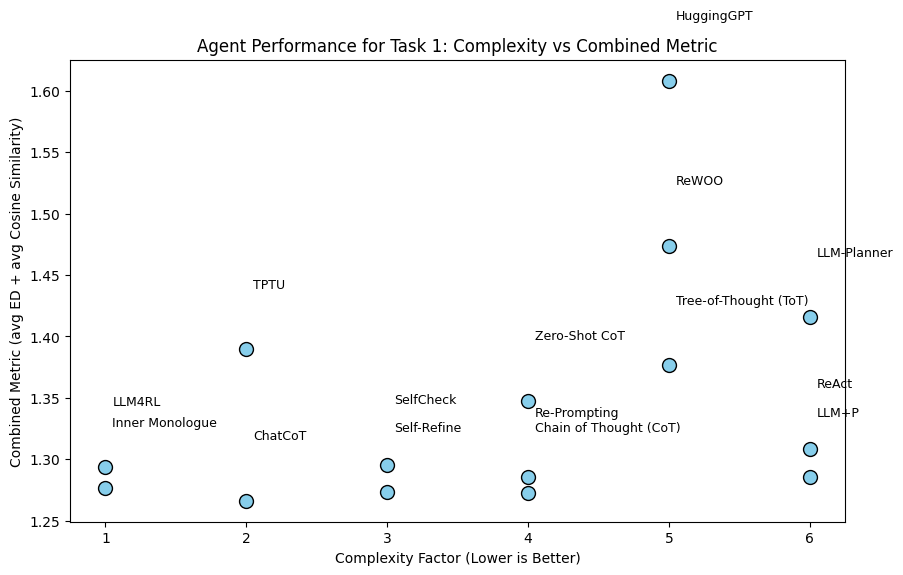

In [ ]:
#Block H: Complexity Factor–Based Agent Performance Analysis for Task 1
import psycopg2
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# --------------------------------------
# 1) Database Connection Configuration
# --------------------------------------
DB_CONFIG = {
    "dbname": "agents_db",
    "user": "gauraangmalik",
    "password": "your_password",  # Replace with your actual password
    "host": "localhost",
    "port": 5432
}

# --------------------------------------
# 2) Define Complexity Mapping
# --------------------------------------
# Lower values indicate less complexity (i.e. a better answer).
# Adjust these values as needed.
complexity_mapping = {
    "Chain of Thought (CoT)": 4,
    "Zero-Shot CoT": 4,
    "Re-Prompting": 4,
    "ReWOO": 5,
    "HuggingGPT": 5,
    "Tree-of-Thought (ToT)": 5,
    "LLM-Planner": 6,
    "ReAct": 6,
    "LLM+P": 6,
    "Inner Monologue": 1,
    "LLM4RL": 1,
    "ChatCoT": 2,
    "TPTU": 2,
    "Self-Refine": 3,
    "SelfCheck": 3
}

# --------------------------------------
# 3) Fetch agent_pair_performance Data for Task 1
# --------------------------------------
with psycopg2.connect(**DB_CONFIG) as conn:
    df_pair = pd.read_sql("SELECT * FROM agent_pair_performance WHERE task_name = '1';", conn)

print("Agent Pair Performance for Task 1 (first few rows):")
print(df_pair.head())

# --------------------------------------
# 4) Aggregate Performance Metrics Per Agent for Task 1
# --------------------------------------
# Each row in df_pair is a pairwise comparison between two agents.
# We want to compute, for each agent, the average metrics from all pairs in which they appear.
agents = set(df_pair['agent1']).union(set(df_pair['agent2']))
agent_metrics = []

for agent in agents:
    # Select rows where the agent appears as either agent1 or agent2
    rows = df_pair[(df_pair['agent1'] == agent) | (df_pair['agent2'] == agent)]
    if rows.empty:
        continue
    avg_ed = rows['euclidean_distance'].mean()
    avg_cos = rows['cosine_similarity'].mean()
    avg_resp_len = rows['response_length'].mean()
    avg_comp_time = rows['completion_time'].mean()
    # For our combined metric, we simply add average ED and average cosine similarity.
    # (You can change this formula as needed.)
    combined_metric = avg_ed + avg_cos
    # Retrieve the predefined complexity factor; if missing, assign a high default value.
    complexity = complexity_mapping.get(agent, 10)
    agent_metrics.append({
        "agent": agent,
        "avg_euclidean_distance": avg_ed,
        "avg_cosine_similarity": avg_cos,
        "avg_response_length": avg_resp_len,
        "avg_completion_time": avg_comp_time,
        "combined_metric": combined_metric,
        "complexity": complexity
    })

df_agents = pd.DataFrame(agent_metrics)
print("\nAggregated Performance Metrics for Each Agent (Task 1):")
print(df_agents)

# --------------------------------------
# 5) Determine the Best Agent (Least Complex)
# --------------------------------------
# We define the best answer as the one with the lowest complexity factor.
# In case of ties, we choose the one with the lowest combined metric (avg ED + avg cosine similarity).
df_agents = df_agents.sort_values(by=["complexity", "combined_metric"])
best_agent = df_agents.iloc[0]
print("\nBest Agent for Task 1 (Based on Least Complexity):")
print(best_agent)

# --------------------------------------
# 6) Visualize: Scatter Plot of Complexity vs. Combined Metric
# --------------------------------------
plt.figure(figsize=(10, 6))
plt.scatter(df_agents['complexity'], df_agents['combined_metric'], s=100, c='skyblue', edgecolors='k')
for i, row in df_agents.iterrows():
    plt.text(row['complexity'] + 0.05, row['combined_metric'] + 0.05, row['agent'], fontsize=9)
plt.xlabel("Complexity Factor (Lower is Better)")
plt.ylabel("Combined Metric (avg ED + avg Cosine Similarity)")
plt.title("Agent Performance for Task 1: Complexity vs Combined Metric")
plt.show()
